In [1]:
import os
import re
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

def load_combined_data(
    pte_directory,         # Directory containing the PTE .npz files
    DE_directory,         # Directory containing the PSD .npz files
    target_participant,
    batch_size,
    selected_classes=["alz", "ctrl"],   # Which classes to load
    selected_channels=None,             # Channels to select
    apply_smote=True                    # Whether to apply SMOTE on the source data
):
    """
    Load data from separate directories for PTE and PSD, normalize, optionally apply SMOTE,
    and create DataLoaders for source and target domains.

    Args:
        pte_directory (str):
            Path to the directory containing .npz files with PTE data.
        psd_directory (str):
            Path to the directory containing .npz files with PSD data.
        target_participant (int):
            Subject ID to be used as the target domain.
        batch_size (int):
            Batch size for the source DataLoader.
        selected_classes (list):
            List of class labels to include (e.g., ["alz", "ctrl"]).
        selected_channels (list or None):
            List of channel names to select. If None, all channels are used.
        apply_smote (bool):
            If True, SMOTE is applied to the source data to handle class imbalance.

    Returns:
        source_dataloader (DataLoader):
            DataLoader for the source domain with tuples: (pte_data, psd_data, labels, participant_ids).
            If SMOTE is applied, synthetic samples are assigned `participant_id = -1`.
        target_dataloader (DataLoader):
            DataLoader for the target domain with tuples: (pte_data, psd_data, labels).
    """
    # -------------------------------------------------------------------------
    # 1) Setup
    # -------------------------------------------------------------------------
    ch_names = [
        'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
        'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
    ]
    label_map = {cname: idx for idx, cname in enumerate(selected_classes)}

    if selected_channels is None:
        selected_channels = ch_names

    # Get channel indices
    try:
        selected_indices = [ch_names.index(ch) for ch in selected_channels]
    except ValueError as e:
        raise ValueError(f"One or more selected channels are not in ch_names: {e}")

    # -------------------------------------------------------------------------
    # 2) Collect and sort .npz files for PTE and PSD
    # -------------------------------------------------------------------------
    pte_files = [f for f in os.listdir(pte_directory) if f.endswith(".npz")]
    psd_files = [f for f in os.listdir(DE_directory) if f.endswith(".npz")]

    # Sort by subject ID (assuming filenames like 'sub-10_*_alz.npz')
    def extract_sub_id(filename):
        match = re.search(r'sub-(\d+)_.*\.npz', filename)
        return int(match.group(1)) if match else -1

    pte_files_sorted = sorted(pte_files, key=extract_sub_id)
    psd_files_sorted = sorted(psd_files, key=extract_sub_id)

    # -------------------------------------------------------------------------
    # 3) Prepare lists for source and target data (with participant IDs)
    # -------------------------------------------------------------------------
    source_pte_data_list, source_pte_labels_list, source_pte_pid_list = [], [], []
    target_pte_data_list, target_pte_labels_list = [], []
    source_psd_data_list, source_psd_labels_list, source_psd_pid_list = [], [], []
    target_psd_data_list, target_psd_labels_list = [], []

    # Separate MinMaxScalers for PTE and PSD
    pte_scaler = MinMaxScaler()
    psd_scaler = MinMaxScaler()

    # -------------------------------------------------------------------------
    # 4) Load PTE data
    # -------------------------------------------------------------------------
    for file in pte_files_sorted:
        match = re.search(r'sub-(\d+)_.*_(\w+)\.npz', file)
        if not match:
            continue
        subject_id = int(match.group(1))
        label_str = match.group(2).lower()

        # Skip if label not in selected classes
        if label_str not in selected_classes:
            continue

        label_idx = label_map[label_str]
        full_path = os.path.join(pte_directory, file)

        data_npz = np.load(full_path, allow_pickle=True)
        if "pte_data" not in data_npz:
            continue  # no PTE data

        pte_data = data_npz["pte_data"]  # shape: [N, 12, 5, 19, 19] (example)

        # Select channels in the 4th and 5th dimensions (adjust if shape differs)
        # For example: pte_data[:, :11, :, selected_indices, :][:, :11, :, :, selected_indices]
        # Modify as needed for your real data shape
        pte_data = pte_data[:, :11, :, selected_indices, :][:, :11, :, :, selected_indices]

        # Normalize across the last dimension
        orig_shape = pte_data.shape
        pte_data_flat = pte_data.reshape(-1, orig_shape[-1])
        pte_data_flat = pte_scaler.fit_transform(pte_data_flat)
        pte_data = pte_data_flat.reshape(orig_shape)

        # Build labels
        labels = np.full((pte_data.shape[0],), label_idx, dtype=int)

        if subject_id == target_participant:
            # Target domain
            target_pte_data_list.append(pte_data)
            target_pte_labels_list.append(labels)
        else:
            # Source domain
            source_pte_data_list.append(pte_data)
            source_pte_labels_list.append(labels)
            # Store participant IDs (one per sample)
            source_pte_pid_list.extend([subject_id] * pte_data.shape[0])

    # -------------------------------------------------------------------------
    # 5) Load PSD data
    # -------------------------------------------------------------------------
    for file in psd_files_sorted:
        match = re.search(r'sub-(\d+)_.*_(\w+)\.npz', file)
        if not match:
            continue
        subject_id = int(match.group(1))
        label_str = match.group(2).lower()

        if label_str not in selected_classes:
            continue

        label_idx = label_map[label_str]
        full_path = os.path.join(DE_directory, file)

        data_npz = np.load(full_path, allow_pickle=True)
        if "DE_features" not in data_npz:
            continue

        psd_data = data_npz["DE_features"]  # shape: [N, 12, n_channels, n_bands], etc.
        # print(psd_data.shape)
        
        # Select channels (assume 2nd dimension is channels):
        # e.g., psd_data[:, :, selected_indices, :]
        psd_data = psd_data[:, selected_indices, :]

        # Normalize
        orig_shape = psd_data.shape
        psd_data_flat = psd_data.reshape(-1, orig_shape[-1])
        psd_data_flat = psd_scaler.fit_transform(psd_data_flat)
        psd_data = psd_data_flat.reshape(orig_shape)

        labels = np.full((psd_data.shape[0],), label_idx, dtype=int)

        if subject_id == target_participant:
            target_psd_data_list.append(psd_data)
            target_psd_labels_list.append(labels)
        else:
            source_psd_data_list.append(psd_data)
            source_psd_labels_list.append(labels)
            source_psd_pid_list.extend([subject_id] * psd_data.shape[0])

    # -------------------------------------------------------------------------
    # 6) Concatenate source & target data
    # -------------------------------------------------------------------------
    def concat_arrays(array_list):
        return np.concatenate(array_list, axis=0) if array_list else None

    # Source PTE
    source_pte_data = concat_arrays(source_pte_data_list)
    source_pte_labels = concat_arrays(source_pte_labels_list)
    source_pte_pids = np.array(source_pte_pid_list) if source_pte_pid_list else None

    # Target PTE
    target_pte_data = concat_arrays(target_pte_data_list)
    target_pte_labels = concat_arrays(target_pte_labels_list)

    # Source PSD
    source_psd_data = concat_arrays(source_psd_data_list)
    source_psd_labels = concat_arrays(source_psd_labels_list)
    source_psd_pids = np.array(source_psd_pid_list) if source_psd_pid_list else None

    # Target PSD
    target_psd_data = concat_arrays(target_psd_data_list)
    target_psd_labels = concat_arrays(target_psd_labels_list)

    # print("\nSource PTE data shape:", source_pte_data.shape if source_pte_data is not None else None)
    # print("Source PSD data shape:", source_psd_data.shape if source_psd_data is not None else None)
    # print("Target PTE data shape:", target_pte_data.shape if target_pte_data is not None else None)
    # print("Target PSD data shape:", target_psd_data.shape if target_psd_data is not None else None)
    
    # Quick sanity check
    if (
        source_pte_data is None or source_pte_labels is None or
        source_psd_data is None or source_psd_labels is None
    ):
        raise ValueError("No valid source data found (PTE or PSD).")
    if (
        target_pte_data is None or target_pte_labels is None or
        target_psd_data is None or target_psd_labels is None
    ):
        raise ValueError("No valid target data found (PTE or PSD).")

    # -------------------------------------------------------------------------
    # 7) Optionally apply SMOTE on the source data
    # -------------------------------------------------------------------------
    if apply_smote:
        print("\nApplying SMOTE to the source data...")

        # Flatten PTE and PSD for concatenation
        orig_pte_shape = source_pte_data.shape
        orig_psd_shape = source_psd_data.shape

        pte_flat = source_pte_data.reshape(orig_pte_shape[0], -1)
        psd_flat = source_psd_data.reshape(orig_psd_shape[0], -1)

        # Concatenate features for SMOTE
        combined_features = np.concatenate([pte_flat, psd_flat], axis=1)
        combined_labels = source_pte_labels  # same as PSD labels in your setup

        # SMOTE
        sm = SMOTE(random_state=42)
        combined_resampled, labels_resampled = sm.fit_resample(combined_features, combined_labels)

        # Count how many new (synthetic) samples were added
        num_original = combined_features.shape[0]
        num_new = combined_resampled.shape[0] - num_original
        print(f"SMOTE created {num_new} synthetic samples.")

        # Split back into PTE and PSD
        pte_dim = pte_flat.shape[1]
        psd_dim = psd_flat.shape[1]

        pte_resampled = combined_resampled[:, :pte_dim]
        psd_resampled = combined_resampled[:, pte_dim:]

        # Reshape back
        source_pte_data = pte_resampled.reshape(
            -1,
            orig_pte_shape[1],
            orig_pte_shape[2],
            orig_pte_shape[3],
            orig_pte_shape[4]
        )
        source_psd_data = psd_resampled.reshape(
            -1,
            orig_psd_shape[1],
            orig_psd_shape[2]
        )

        # Update labels
        source_pte_labels = labels_resampled
        source_psd_labels = labels_resampled

        # For new (synthetic) samples, assign participant_id = -1 so they can be excluded in threshold tuning
        pid_extended = np.concatenate([
            source_pte_pids,
            np.full(num_new, -1, dtype=int)
        ])
        source_pte_pids = pid_extended
        source_psd_pids = pid_extended
    else:
        print("\nSMOTE not applied to the source data.")

    # -------------------------------------------------------------------------
    # 8) Convert to PyTorch Tensors
    # -------------------------------------------------------------------------
    def to_tensor(data, dtype=torch.float):
        return torch.from_numpy(data).type(dtype)

    source_pte_data_tensor = to_tensor(source_pte_data, torch.float)
    source_psd_data_tensor = to_tensor(source_psd_data, torch.float)
    source_labels_tensor = to_tensor(source_pte_labels, torch.long)
    source_pid_tensor = to_tensor(source_pte_pids, torch.long)

    target_pte_data_tensor = to_tensor(target_pte_data, torch.float)
    target_psd_data_tensor = to_tensor(target_psd_data, torch.float)
    target_labels_tensor = to_tensor(target_pte_labels, torch.long)
    # Target doesn't need a participant ID (single participant).

    # -------------------------------------------------------------------------
    # 9) Build TensorDatasets & DataLoaders
    # -------------------------------------------------------------------------
    # Source dataset has participant IDs so we can do threshold tuning
    source_dataset = TensorDataset(
        source_pte_data_tensor,
        source_psd_data_tensor,
        source_labels_tensor,
        source_pid_tensor
    )
    target_dataset = TensorDataset(
        target_pte_data_tensor,
        target_psd_data_tensor,
        target_labels_tensor
    )

    source_dataloader = DataLoader(
        source_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    target_dataloader = DataLoader(
        target_dataset, batch_size=len(target_dataset), shuffle=False, drop_last=False
    )

    return source_dataloader, target_dataloader


# ------------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    selected_channels = ['O2', 'C3', 'C4', 'Cz', 'T5', 'T6']
    source_dataloader, target_dataloader = load_combined_data(
        pte_directory="features",
        DE_directory="DE_features_single_window",
        target_participant=6,
        batch_size=32,
        selected_classes=["ctrl", "alz"],
        selected_channels=selected_channels,
        apply_smote=True    # Control SMOTE usage here
    )
    print(f"\nSource data: {len(source_dataloader.dataset)} samples (including any synthetic)")
    print(f"Target data: {len(target_dataloader.dataset)} samples (single participant)")

    # Check a sample from the source DataLoader
    for pte_batch, psd_batch, labels_batch, pid_batch in source_dataloader:
        print("PTE Batch Shape:", pte_batch.shape)
        print("PSD Batch Shape:", psd_batch.shape)
        print("Labels Batch Shape:", labels_batch.shape)
        print("Participant IDs Batch Shape:", pid_batch.shape)
        break

    # Check the target DataLoader
    for pte_batch, psd_batch, labels_batch in target_dataloader:
        print("TARGET PTE Batch Shape:", pte_batch.shape)
        print("TARGET PSD Batch Shape:", psd_batch.shape)
        print("TARGET Labels Shape:", labels_batch.shape)
        break



Applying SMOTE to the source data...
SMOTE created 71 synthetic samples.

Source data: 918 samples (including any synthetic)
Target data: 10 samples (single participant)
PTE Batch Shape: torch.Size([32, 11, 5, 6, 6])
PSD Batch Shape: torch.Size([32, 6, 5])
Labels Batch Shape: torch.Size([32])
Participant IDs Batch Shape: torch.Size([32])
TARGET PTE Batch Shape: torch.Size([10, 11, 5, 6, 6])
TARGET PSD Batch Shape: torch.Size([10, 6, 5])
TARGET Labels Shape: torch.Size([10])


In [3]:
import math
import torch
from itertools import cycle
import torch.nn.functional as F


def train_model(
    model,
    source_dataloader,
    target_dataloader,
    criterion_label,
    criterion_domain,
    optimizer,
    num_epochs=10,
    device="cuda",
    alpha_entropy = 0.01
):
   
    model.to(device)
    model.train()

    accuracy_history = []
    domain_accuracy_history = []

    # Create an infinite iterator over the target dataloader
    target_iter = cycle(target_dataloader)

    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0
        total_domain_correct = 0
        total_domain_samples = 0

        epoch_loss = 0.0


        for i, batch_src in enumerate(source_dataloader):

            if len(batch_src) == 4:
                source_pte, source_psd, source_labels, _ = batch_src
            else:
                source_pte, source_psd, source_labels = batch_src

            # Grab target batch
            batch_tgt = next(target_iter)
            if len(batch_tgt) == 3:
                target_pte, target_psd, _ = batch_tgt
            else:
                # e.g., (target_pte, target_psd) if unlabeled
                target_pte, target_psd = batch_tgt


            # Move data to device
            source_pte = source_pte.to(device)
            source_psd = source_psd.to(device)
            source_labels = source_labels.to(device)

            target_pte = target_pte.to(device)
            target_psd = target_psd.to(device)


            label_preds, _ = model(
                source_pte, source_psd
            )
 
            label_preds_target, _ = model(
                target_pte, target_psd
            )


            loss_label = criterion_label(label_preds, source_labels)


            total_loss = loss_label
            # Backward + Optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # -------------------------------
            # Update Metrics
            # -------------------------------
            epoch_loss += loss_label.item()

            # Label prediction accuracy (source)
            _, predicted = torch.max(label_preds, dim=1)
            correct = (predicted == source_labels).sum().item()
            total_correct += correct
            total_samples += source_labels.size(0)


        epoch_accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0
        epoch_domain_accuracy = 100.0 * total_domain_correct / total_domain_samples if total_domain_samples > 0 else 0

        accuracy_history.append(epoch_accuracy)
        domain_accuracy_history.append(epoch_domain_accuracy)

        # print(f"Epoch [{epoch+1}/{num_epochs}] "
        #       f"Label Acc: {epoch_accuracy:.2f}%, "
        #       f"Domain Acc: {epoch_domain_accuracy:.2f}%")

    return accuracy_history, domain_accuracy_history


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Tuple
from sklearn.metrics import f1_score
from collections import Counter

def test_model(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    criterion_label: torch.nn.Module,
    device: str = "cuda",
    num_classes: int = 2,
    alz_threshold: float = 0.4
) -> Tuple[float, float, float, np.ndarray, np.ndarray, np.ndarray, float, int]:
  
    model.to(device)
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_preds_softmax = []

    with torch.no_grad():
        for batch in test_dataloader:
            # ------------------------------------------------------
            # 1) Handle batch size: 3 items or 4 items
            # ------------------------------------------------------
            # If your test dataloader returns 4 items (pte_batch, psd_batch, labels, pid):
            if len(batch) == 4:
                pte_batch, psd_batch, labels, _ = batch
            elif len(batch) == 3:
                pte_batch, psd_batch, labels = batch
            else:
                raise ValueError(
                    f"DataLoader should return (pte_batch, psd_batch, labels) or 4 items. Got {len(batch)} items."
                )

            # Move data to device
            pte_batch = pte_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)

          
            label_preds, _ = model(pte_batch, psd_batch)

            # ------------------------------------------------------
            # 4) Compute classification loss
            # ------------------------------------------------------
            loss = criterion_label(label_preds, labels)
            total_loss += loss.item()

            # ------------------------------------------------------
            # 5) Softmax for predicted probabilities
            # ------------------------------------------------------
            softmax_output = F.softmax(label_preds, dim=1)

            # ------------------------------------------------------
            # 6) Hard predictions
            # ------------------------------------------------------
            _, predicted = torch.max(softmax_output, dim=1)

            # ------------------------------------------------------
            # 7) Store predictions/probabilities/labels
            # ------------------------------------------------------
            all_preds.extend(predicted.cpu().numpy())
            all_preds_softmax.extend(softmax_output.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ------------------------------------------------------
    # 8) Compute average loss
    # ------------------------------------------------------
    if len(test_dataloader) > 0:
        avg_loss = total_loss / len(test_dataloader)
    else:
        avg_loss = 0.0

    # ------------------------------------------------------
    # 9) Check if the participant has a single ground-truth label
    # ------------------------------------------------------
    all_labels = np.array(all_labels)
    unique_lbls = np.unique(all_labels)
    if len(unique_lbls) != 1:
        raise ValueError(
            f"Participant's test set has multiple labels: {unique_lbls}. "
            f"Expected exactly 1 label per participant."
        )

    participant_true_label = unique_lbls[0]

    # ------------------------------------------------------
    # 10) Participant-level prediction
    # ------------------------------------------------------
    all_preds = np.array(all_preds)
    alz_count = np.sum(all_preds == 1)
    alz_ratio = alz_count / max(len(all_preds), 1)

    if alz_ratio >= alz_threshold:
        participant_pred_label = 1
    else:
        participant_pred_label = 0

    # ------------------------------------------------------
    # 11) Construct participant-level confusion matrix
    # ------------------------------------------------------
    participant_conf_mat = np.zeros((num_classes, num_classes), dtype=int)
    participant_conf_mat[participant_true_label, participant_pred_label] += 1

    # ------------------------------------------------------
    # 12) Participant-level accuracy & F1
    # ------------------------------------------------------
    participant_acc = 100.0 if (participant_true_label == participant_pred_label) else 0.0

    from sklearn.metrics import f1_score
    participant_f1 = f1_score(
        [participant_true_label],
        [participant_pred_label],
        average='macro',
        zero_division=0
    )

    # ------------------------------------------------------
    # 13) Print debug info
    # ------------------------------------------------------
    print(f"\nParticipant True Label: {participant_true_label}")
    print(f" -> #Predicted ALZ samples: {alz_count} / {len(all_preds)} = {alz_ratio:.2f}")
    print(f" -> Threshold = {alz_threshold}; Final Participant Prediction: {participant_pred_label}")
    print(f" -> Participant Accuracy: {participant_acc:.2f}%")
    print(f" -> Participant F1 (Macro): {participant_f1:.4f}")

    # ------------------------------------------------------
    # 14) Return results including alz_ratio and true label
    # ------------------------------------------------------
    all_preds_softmax = np.array(all_preds_softmax)  # shape: [N, num_classes]
    return (
        avg_loss,
        participant_acc,
        participant_f1,
        participant_conf_mat,
        all_preds_softmax,
        all_labels,
        alz_ratio,
        participant_true_label
    )



In [5]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score

def tune_threshold_on_source(
    model,
    source_dataloader,
    device="cuda",
    thresholds=[0.1, 0.2, 0.3, 0.4, 0.5],
    num_classes=2
):

    model.eval()
    model.to(device)
    sample_preds = defaultdict(list)
    participant_label = {}

    with torch.no_grad():
        for batch in source_dataloader:
            # If your source dataloader returns 4 items, including participant_id
            if len(batch) == 4:
                pte_batch, psd_batch, labels, pid_batch = batch
            else:
                raise ValueError("Expected Dataloader to return (pte, psd, labels, pid).")

            pte_batch = pte_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            pid_batch = pid_batch.to(device)

            # Forward pass (disable GRL in inference by setting lambda_=0)
            label_preds, _ = model(pte_batch, psd_batch)

            # Convert predictions to class=0/1
            softmax_output = F.softmax(label_preds, dim=1)
            _, predicted = torch.max(softmax_output, dim=1)

            # Move to CPU
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            pid_batch = pid_batch.cpu().numpy()

            # Store predictions for each participant
            for pred, true_lbl, pid in zip(predicted, labels, pid_batch):
                sample_preds[pid].append(pred)
                # We assume all samples from participant pid share the same ground-truth label:
                if pid not in participant_label:
                    participant_label[pid] = true_lbl
                else:
                    # Optionally check that the label is consistent
                    if participant_label[pid] != true_lbl:
                        raise ValueError(f"Inconsistent labels for participant {pid} in source data.")

    # Now we have sample-level predictions per participant. We'll try each threshold.
    best_threshold = None
    best_metric_val = -1.0

    for thr in thresholds:
        # For each threshold, generate participant-level predictions
        # by counting how many samples predicted as class=1
        part_level_preds = []
        part_level_trues = []

        for pid, preds_list in sample_preds.items():
            true_lbl = participant_label[pid]
            n_alz = sum([p == 1 for p in preds_list])
            ratio = float(n_alz) / len(preds_list)
            # Decide participant-level label
            if ratio >= thr:
                participant_pred = 1
            else:
                participant_pred = 0
            
            part_level_preds.append(participant_pred)
            part_level_trues.append(true_lbl)

        # Evaluate participant-level performance
        # For example, we use F1 (macro):
        f1 = f1_score(part_level_trues, part_level_preds, average='macro', zero_division=0)
        acc = accuracy_score(part_level_trues, part_level_preds)

        print(f"[Threshold {thr}] -> F1={f1:.4f} | Acc={acc:.4f}")

        # Suppose we pick the threshold that maximizes participant-level F1
        if f1 > best_metric_val:
            best_metric_val = f1
            best_threshold = thr

    print(f"\n[Best Threshold] = {best_threshold} with F1={best_metric_val:.4f}")
    return best_threshold


In [10]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math


# Define the Multi-Head Cross Attention Module
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):

        super(MultiHeadCrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):

        # Apply MultiheadAttention; note that nn.MultiheadAttention expects inputs of shape (batch, seq, feature)
        attn_output, attn_weights = self.multihead_attn(query, key, value, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        
        # Apply dropout
        attn_output = self.dropout(attn_output)
        
        # Add & Norm
        output = self.layer_norm(query + attn_output)
        
        return output, attn_weights

# Existing Transformer Classes (PteTransformer and PsdTransformer)
class PteTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout):
        super(PteTransformer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.dropout = dropout
        self.position_encoding = nn.Parameter(torch.randn(1, 11, input_dim), requires_grad=True)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, output_dim)  # Project to desired output_dim

    def forward(self, x):
        """
        x: (batch_size, original_features)
        """
        b = x.shape[0]
        # Reshape to (batch_size, 11, input_dim//11) assuming input_dim is divisible by 11
        x = x.reshape(b, 11, -1)
        x = self.position_encoding + x  # (batch_size, 11, input_dim)
        x = self.transformer(x)         # (batch_size, 11, input_dim)
        x = self.output_layer(x)        # (batch_size, 11, output_dim)
        return x

class PsdTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout):
        super(PsdTransformer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.dropout = dropout

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, output_dim)  # Project to desired output_dim

    def forward(self, x):
        """
        x: (batch_size, original_features)
        """
        # Assuming x is already of shape (batch_size, T_e, input_dim)
        x = self.transformer(x)         # (batch_size, T_e, input_dim)
        x = self.output_layer(x)        # (batch_size, T_e, output_dim)
        return x

# Updated Final Model with Multi-Head Cross Attention and DANN Components
class FinalModel(nn.Module):
    def __init__(self, 
                 pte_input_dim, pte_hidden_dim, pte_num_layers, pte_num_heads, pte_output_dim, pte_dropout,
                 psd_input_dim, psd_hidden_dim, psd_num_layers, psd_num_heads, psd_output_dim, psd_dropout,
                 cross_d_model, cross_num_heads,
                 ):
        super(FinalModel, self).__init__() 

        # Initialize PTE and PSD Transformers
        self.pte_transformer = PteTransformer(
            input_dim=pte_input_dim,
            hidden_dim=pte_hidden_dim,
            num_layers=pte_num_layers,
            num_heads=pte_num_heads,
            output_dim=pte_output_dim,
            dropout=pte_dropout
        )
        
        self.psd_transformer = PsdTransformer(
            input_dim=psd_input_dim,
            hidden_dim=psd_hidden_dim,
            num_layers=psd_num_layers,
            num_heads=psd_num_heads,
            output_dim=psd_output_dim,
            dropout=psd_dropout
        )
        
        # Initialize Multi-Head Cross-Attention
        self.cross_attention = MultiHeadCrossAttention(
            d_model=cross_d_model,
            num_heads=cross_num_heads,
            dropout=0.1
        )

        # Final Classifier for Label Prediction
        self.final_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(768, 2)  # Adjust based on the sequence length (12 here)
        )
        
    def forward(self, pte_input, psd_input):

        # Pass through respective transformers
        # pte_encoded = self.pte_transformer(pte_input)  # (batch_size, T_pte=11, pte_output_dim=128)
        psd_encoded = self.psd_transformer(psd_input)  # (batch_size, T_psd=6, psd_output_dim=128)
        
        
        # Label Prediction
        label_pred = self.final_classifier(psd_encoded)  # (batch_size, 2)
        
        
        return label_pred, None

# Example usage
if __name__ == "__main__":
    # Example input tensors
    # Adjust the shapes based on your actual data
    # For illustration, assuming:
    # pte_input has 11 time steps, each with (input_dim_pte / 11) features
    x_1 = torch.randn(32, 11 * 5 * 6 * 6)  # (batch_size, pte_original_features)
    # psd_input has sequence length 6 with 5 features each
    x_2 = torch.randn(32, 6, 5)            # (batch_size, psd_seq_length, psd_original_features)
    
    # Define the model parameters
    input_dim_pte = 180   # Example: 11 * 5 * 6 * 6 = 180
    hidden_dim_pte = 512
    num_layers_pte = 2
    num_heads_pte = 5     # Typically, num_heads should divide d_model
    output_dim_pte = 128
    dropout_pte = 0.1
    
    input_dim_psd = 5
    hidden_dim_psd = 512
    num_layers_psd = 2
    num_heads_psd = 5    # Typically, num_heads should divide d_model
    output_dim_psd = 128
    dropout_psd = 0.1
    
    cross_d_model = 128
    cross_num_heads = 8   # Number of heads in cross-attention
    
    # Initialize the DANN model
    model = FinalModel(
        pte_input_dim=input_dim_pte, 
        pte_hidden_dim=hidden_dim_pte, 
        pte_num_layers=num_layers_pte, 
        pte_num_heads=num_heads_pte, 
        pte_output_dim=output_dim_pte, 
        pte_dropout=dropout_pte,
        psd_input_dim=input_dim_psd, 
        psd_hidden_dim=hidden_dim_psd, 
        psd_num_layers=num_layers_psd, 
        psd_num_heads=num_heads_psd, 
        psd_output_dim=output_dim_psd, 
        psd_dropout=dropout_psd,
        cross_d_model=cross_d_model, 
        cross_num_heads=cross_num_heads
    )
    
    # Example forward pass
    label_pred, _ = model(x_1, x_2)
    print("Label Prediction Shape:", label_pred.shape)        # Expected: (32, 2)


Label Prediction Shape: torch.Size([32, 2])


In [11]:
import random
import numpy as np
import torch
from sklearn.utils import check_random_state

def set_seed(seed):
    random.seed(seed)

    # Set the seed for numpy
    np.random.seed(seed)

    # Set the seed for PyTorch (both CPU and CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in PyTorch (if applicable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the seed for sklearn (via check_random_state)
    _ = check_random_state(seed)

    print(f"Seed set to: {seed}")


In [20]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
from statistics import mode, StatisticsError
import matplotlib.pyplot as plt

# Initialize accumulators for participant-level metrics
participant_scores = []       # Aggregated scores (e.g., alz_ratio) per participant
participant_labels_list = []  # Ground-truth labels per participant

seed = 42
set_seed(seed)  # Ensure reproducibility

# Define the model parameters
# Define the model parameters
input_dim_pte = 180   # Example: 11 * 5 * 6 * 6 = 180
hidden_dim_pte = 512
num_layers_pte = 2
num_heads_pte = 5     # Typically, num_heads should divide d_model
output_dim_pte = 128
dropout_pte = 0.4

input_dim_psd = 5
hidden_dim_psd = 512
num_layers_psd = 2
num_heads_psd = 5    # Typically, num_heads should divide d_model
output_dim_psd = 128
dropout_psd = 0.4

cross_d_model = 128
cross_num_heads = 8   # Number of heads in cross-attention

# Accumulators for overall metrics
all_acc = []
all_f1 = []
all_conf = []

# For global sample-level AUC
global_probs = []
global_labels = []

best_thresholds = []  # Store the chosen threshold for each participant

for participant in range(1, 66):
    print(f"\n===== Training for participant: {participant} =====")

    # --------------------------
    # 1) Initialize the model
    # --------------------------
    model = FinalModel(
        pte_input_dim=input_dim_pte, 
        pte_hidden_dim=hidden_dim_pte, 
        pte_num_layers=num_layers_pte, 
        pte_num_heads=num_heads_pte, 
        pte_output_dim=output_dim_pte, 
        pte_dropout=dropout_pte,
        psd_input_dim=input_dim_psd, 
        psd_hidden_dim=hidden_dim_psd, 
        psd_num_layers=num_layers_psd, 
        psd_num_heads=num_heads_psd, 
        psd_output_dim=output_dim_psd, 
        psd_dropout=dropout_psd,
        cross_d_model=cross_d_model, 
        cross_num_heads=cross_num_heads
    )

    # --------------------------
    # 2) Load data
    #    (Ensure your source_dataloader returns (pte, psd, labels, participant_id))
    # --------------------------
    source_dataloader, target_dataloader = load_combined_data(
        pte_directory="features",
        DE_directory="DE_features_single_window",
        target_participant=participant,
        batch_size=128,
        selected_classes=["ctrl", "alz"],
        selected_channels=selected_channels,
        apply_smote=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Source data: {len(source_dataloader.dataset)} samples")
    print(f"Target data: {len(target_dataloader.dataset)} samples")

    # --------------------------
    # 3) Define Loss & Optimizer
    # --------------------------
    class_weights = torch.tensor([0.8, 1.0], dtype=torch.float32, device=device)
    criterion_label = nn.CrossEntropyLoss(weight=class_weights)
    criterion_domain = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-5) # 8e-5

    # --------------------------
    # 4) Train Model (DANN)
    # --------------------------
    num_epochs = 100
    lambda_grl = 0.0  # or use a schedule
    label_acc_history, domain_acc_history = train_model(
        model=model,
        source_dataloader=source_dataloader,
        target_dataloader=target_dataloader,
        criterion_label=criterion_label,
        criterion_domain=criterion_domain,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device    )
    print(f"Final Training Label Accuracy: {label_acc_history[-1]:.2f}%")

    # --------------------------
    # 5) Tune Threshold on Source
    # --------------------------
    # This step requires that your source_dataloader yield participant IDs
    thresholds_to_try = [0.2, 0.3, 0.4, 0.5]
    best_thr = tune_threshold_on_source(
        model=model,
        source_dataloader=source_dataloader,
        device=device,
        thresholds=thresholds_to_try,
        num_classes=2
    )
    best_thresholds.append(best_thr)

    # --------------------------
    # 6) Test on Target
    # --------------------------
    # We use the threshold we found above
    test_loss, test_acc, test_f1_score_part, participant_conf_mat, \
        participant_preds_softmax, participant_labels, alz_ratio, participant_true_label = test_model(
            model=model,
            test_dataloader=target_dataloader,
            criterion_label=criterion_label,
            device=device,
            num_classes=2,
            alz_threshold=best_thr,  # <--- using the best threshold
    )

    # --------------------------
    # 7) Store Participant-Level Metrics
    # --------------------------
    all_acc.append(test_acc)
    all_f1.append(test_f1_score_part)
    all_conf.append(participant_conf_mat)

    global_probs.append(participant_preds_softmax)
    global_labels.append(participant_labels)

    # Collect participant-level score and label for ROC AUC
    participant_scores.append(alz_ratio)               # Using alz_ratio as the score
    participant_labels_list.append(participant_true_label)  # Ground-truth label


Seed set to: 42

===== Training for participant: 1 =====

Applying SMOTE to the source data...
SMOTE created 72 synthetic samples.
Source data: 920 samples
Target data: 9 samples


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final Training Label Accuracy: 71.43%
[Threshold 0.2] -> F1=0.7111 | Acc=0.7385
[Threshold 0.3] -> F1=0.8077 | Acc=0.8154
[Threshold 0.4] -> F1=0.8582 | Acc=0.8615
[Threshold 0.5] -> F1=0.8610 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8610

Participant True Label: 1
 -> #Predicted ALZ samples: 6 / 9 = 0.67
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 2 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 70.54%
[Threshold 0.2] -> F1=0.6771 | Acc=0.7077
[Threshold 0.3] -> F1=0.7611 | Acc=0.7692
[Threshold 0.4] -> F1=0.8293 | Acc=0.8308
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 13 = 0.62
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 3 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 76 synthetic samples.
Source data: 928 samples
Target data: 5 samples
Final Training Label Accuracy: 68.42%
[Threshold 0.2] -> F1=0.6908 | Acc=0.7231
[Threshold 0.3] -> F1=0.8397 | Acc=0.8462
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 1 / 5 = 0.20
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 4 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 70 synthetic samples.
Source data: 916 samples
Target data: 11 samples
Final Training Label Accuracy: 66.18%
[Threshold 0.2] -> F1=0.7400 | Acc=0.7538
[Threshold 0.3] -> F1=0.8452 | Acc=0.8462
[Threshold 0.4] -> F1=0.8614 | Acc=0.8615
[Threshold 0.5] -> F1=0.8769 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8769

Participant True Label: 1
 -> #Predicted ALZ samples: 11 / 11 = 1.00
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 5 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 69.20%
[Threshold 0.2] -> F1=0.7725 | Acc=0.7846
[Threshold 0.3] -> F1=0.8582 | Acc=0.8615
[Threshold 0.4] -> F1=0.8610 | Acc=0.8615
[Threshold 0.5] -> F1=0.8461 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8610

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 13 = 0.62
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 6 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 71 synthetic samples.
Source data: 918 samples
Target data: 10 samples
Final Training Label Accuracy: 68.42%
[Threshold 0.2] -> F1=0.7871 | Acc=0.8000
[Threshold 0.3] -> F1=0.7783 | Acc=0.7846
[Threshold 0.4] -> F1=0.8301 | Acc=0.8308
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 1
 -> #Predicted ALZ samples: 4 / 10 = 0.40
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 7 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 69 synthetic samples.
Source data: 914 samples
Target data: 12 samples
Final Training Label Accuracy: 68.08%
[Threshold 0.2] -> F1=0.7688 | Acc=0.7846
[Threshold 0.3] -> F1=0.8267 | Acc=0.8308
[Threshold 0.4] -> F1=0.9077 | Acc=0.9077
[Threshold 0.5] -> F1=0.8769 | Acc=0.8769

[Best Threshold] = 0.4 with F1=0.9077

Participant True Label: 1
 -> #Predicted ALZ samples: 9 / 12 = 0.75
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 8 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 69.31%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.8416 | Acc=0.8462
[Threshold 0.4] -> F1=0.9228 | Acc=0.9231
[Threshold 0.5] -> F1=0.8615 | Acc=0.8615

[Best Threshold] = 0.4 with F1=0.9228

Participant True Label: 1
 -> #Predicted ALZ samples: 13 / 13 = 1.00
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 9 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 71 synthetic samples.
Source data: 918 samples
Target data: 10 samples
Final Training Label Accuracy: 65.74%
[Threshold 0.2] -> F1=0.6259 | Acc=0.6769
[Threshold 0.3] -> F1=0.8099 | Acc=0.8154
[Threshold 0.4] -> F1=0.8132 | Acc=0.8154
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.5 with F1=0.8153

Participant True Label: 1
 -> #Predicted ALZ samples: 5 / 10 = 0.50
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 10 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 60 synthetic samples.
Source data: 896 samples
Target data: 21 samples
Final Training Label Accuracy: 68.97%
[Threshold 0.2] -> F1=0.7358 | Acc=0.7538
[Threshold 0.3] -> F1=0.8603 | Acc=0.8615
[Threshold 0.4] -> F1=0.8767 | Acc=0.8769
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.4 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 3 / 21 = 0.14
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 11 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 69 synthetic samples.
Source data: 914 samples
Target data: 12 samples
Final Training Label Accuracy: 71.32%
[Threshold 0.2] -> F1=0.7543 | Acc=0.7692
[Threshold 0.3] -> F1=0.8118 | Acc=0.8154
[Threshold 0.4] -> F1=0.8610 | Acc=0.8615
[Threshold 0.5] -> F1=0.8922 | Acc=0.8923

[Best Threshold] = 0.5 with F1=0.8922

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 12 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 65.85%
[Threshold 0.2] -> F1=0.7167 | Acc=0.7385
[Threshold 0.3] -> F1=0.7490 | Acc=0.7538
[Threshold 0.4] -> F1=0.8301 | Acc=0.8308
[Threshold 0.5] -> F1=0.7998 | Acc=0.8000

[Best Threshold] = 0.4 with F1=0.8301

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 14 = 0.57
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 13 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 69.64%
[Threshold 0.2] -> F1=0.7725 | Acc=0.7846
[Threshold 0.3] -> F1=0.8431 | Acc=0.8462
[Threshold 0.4] -> F1=0.8919 | Acc=0.8923
[Threshold 0.5] -> F1=0.8461 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8919

Participant True Label: 1
 -> #Predicted ALZ samples: 12 / 13 = 0.92
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 14 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 66 synthetic samples.
Source data: 908 samples
Target data: 15 samples
Final Training Label Accuracy: 69.64%
[Threshold 0.2] -> F1=0.7543 | Acc=0.7692
[Threshold 0.3] -> F1=0.8431 | Acc=0.8462
[Threshold 0.4] -> F1=0.8762 | Acc=0.8769
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 10 / 15 = 0.67
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 15 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 66 synthetic samples.
Source data: 908 samples
Target data: 15 samples
Final Training Label Accuracy: 67.52%
[Threshold 0.2] -> F1=0.8050 | Acc=0.8154
[Threshold 0.3] -> F1=0.7929 | Acc=0.8000
[Threshold 0.4] -> F1=0.8293 | Acc=0.8308
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 1
 -> #Predicted ALZ samples: 5 / 15 = 0.33
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 16 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 65 synthetic samples.
Source data: 906 samples
Target data: 16 samples
Final Training Label Accuracy: 67.97%
[Threshold 0.2] -> F1=0.6699 | Acc=0.7077
[Threshold 0.3] -> F1=0.7400 | Acc=0.7538
[Threshold 0.4] -> F1=0.8293 | Acc=0.8308
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.4 with F1=0.8293

Participant True Label: 1
 -> #Predicted ALZ samples: 16 / 16 = 1.00
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 17 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 67.52%
[Threshold 0.2] -> F1=0.7756 | Acc=0.7846
[Threshold 0.3] -> F1=0.7833 | Acc=0.7846
[Threshold 0.4] -> F1=0.8308 | Acc=0.8308
[Threshold 0.5] -> F1=0.8458 | Acc=0.8462

[Best Threshold] = 0.5 with F1=0.8458

Participant True Label: 1
 -> #Predicted ALZ samples: 13 / 14 = 0.93
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 18 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 65.85%
[Threshold 0.2] -> F1=0.6564 | Acc=0.6923
[Threshold 0.3] -> F1=0.7436 | Acc=0.7538
[Threshold 0.4] -> F1=0.7657 | Acc=0.7692
[Threshold 0.5] -> F1=0.7983 | Acc=0.8000

[Best Threshold] = 0.5 with F1=0.7983

Participant True Label: 1
 -> #Predicted ALZ samples: 14 / 14 = 1.00
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 19 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 66 synthetic samples.
Source data: 908 samples
Target data: 15 samples
Final Training Label Accuracy: 68.19%
[Threshold 0.2] -> F1=0.7688 | Acc=0.7846
[Threshold 0.3] -> F1=0.8118 | Acc=0.8154
[Threshold 0.4] -> F1=0.8452 | Acc=0.8462
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.4 with F1=0.8452

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 15 = 0.47
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 20 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 69.75%
[Threshold 0.2] -> F1=0.6834 | Acc=0.7077
[Threshold 0.3] -> F1=0.8267 | Acc=0.8308
[Threshold 0.4] -> F1=0.8610 | Acc=0.8615
[Threshold 0.5] -> F1=0.8769 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8769

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 14 = 0.14
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 21 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 66 synthetic samples.
Source data: 908 samples
Target data: 15 samples
Final Training Label Accuracy: 70.65%
[Threshold 0.2] -> F1=0.7725 | Acc=0.7846
[Threshold 0.3] -> F1=0.8755 | Acc=0.8769
[Threshold 0.4] -> F1=0.8461 | Acc=0.8462
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.3 with F1=0.8755

Participant True Label: 1
 -> #Predicted ALZ samples: 0 / 15 = 0.00
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 22 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 70.65%
[Threshold 0.2] -> F1=0.8077 | Acc=0.8154
[Threshold 0.3] -> F1=0.8755 | Acc=0.8769
[Threshold 0.4] -> F1=0.8614 | Acc=0.8615
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.3 with F1=0.8755

Participant True Label: 1
 -> #Predicted ALZ samples: 13 / 13 = 1.00
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 23 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 70.87%
[Threshold 0.2] -> F1=0.8018 | Acc=0.8154
[Threshold 0.3] -> F1=0.8199 | Acc=0.8308
[Threshold 0.4] -> F1=0.8603 | Acc=0.8615
[Threshold 0.5] -> F1=0.8458 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8603

Participant True Label: 1
 -> #Predicted ALZ samples: 1 / 13 = 0.08
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 24 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 69 synthetic samples.
Source data: 914 samples
Target data: 12 samples
Final Training Label Accuracy: 65.62%
[Threshold 0.2] -> F1=0.7543 | Acc=0.7692
[Threshold 0.3] -> F1=0.8582 | Acc=0.8615
[Threshold 0.4] -> F1=0.8922 | Acc=0.8923
[Threshold 0.5] -> F1=0.8461 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8922

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 25 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 70 synthetic samples.
Source data: 916 samples
Target data: 11 samples
Final Training Label Accuracy: 68.19%
[Threshold 0.2] -> F1=0.7871 | Acc=0.8000
[Threshold 0.3] -> F1=0.8267 | Acc=0.8308
[Threshold 0.4] -> F1=0.8767 | Acc=0.8769
[Threshold 0.5] -> F1=0.8769 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8769

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 11 = 0.64
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 26 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 67.97%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.8099 | Acc=0.8154
[Threshold 0.4] -> F1=0.8610 | Acc=0.8615
[Threshold 0.5] -> F1=0.8922 | Acc=0.8923

[Best Threshold] = 0.5 with F1=0.8922

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 14 = 0.57
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 27 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 69.08%
[Threshold 0.2] -> F1=0.6771 | Acc=0.7077
[Threshold 0.3] -> F1=0.7436 | Acc=0.7538
[Threshold 0.4] -> F1=0.7952 | Acc=0.8000
[Threshold 0.5] -> F1=0.7992 | Acc=0.8000

[Best Threshold] = 0.5 with F1=0.7992

Participant True Label: 1
 -> #Predicted ALZ samples: 13 / 13 = 1.00
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 28 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 68.97%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.8248 | Acc=0.8308
[Threshold 0.4] -> F1=0.8919 | Acc=0.8923
[Threshold 0.5] -> F1=0.8923 | Acc=0.8923

[Best Threshold] = 0.5 with F1=0.8923

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 13 = 0.62
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 29 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 69 synthetic samples.
Source data: 914 samples
Target data: 12 samples
Final Training Label Accuracy: 69.42%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.7929 | Acc=0.8000
[Threshold 0.4] -> F1=0.8603 | Acc=0.8615
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8603

Participant True Label: 1
 -> #Predicted ALZ samples: 12 / 12 = 1.00
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 30 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 72 synthetic samples.
Source data: 920 samples
Target data: 9 samples
Final Training Label Accuracy: 68.75%
[Threshold 0.2] -> F1=0.8077 | Acc=0.8154
[Threshold 0.3] -> F1=0.8282 | Acc=0.8308
[Threshold 0.4] -> F1=0.8458 | Acc=0.8462
[Threshold 0.5] -> F1=0.7992 | Acc=0.8000

[Best Threshold] = 0.4 with F1=0.8458

Participant True Label: 1
 -> #Predicted ALZ samples: 9 / 9 = 1.00
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 31 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 62 synthetic samples.
Source data: 900 samples
Target data: 19 samples
Final Training Label Accuracy: 68.97%
[Threshold 0.2] -> F1=0.7688 | Acc=0.7846
[Threshold 0.3] -> F1=0.8755 | Acc=0.8769
[Threshold 0.4] -> F1=0.8767 | Acc=0.8769
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 10 / 19 = 0.53
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 32 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 68 synthetic samples.
Source data: 912 samples
Target data: 13 samples
Final Training Label Accuracy: 69.87%
[Threshold 0.2] -> F1=0.7111 | Acc=0.7385
[Threshold 0.3] -> F1=0.7257 | Acc=0.7385
[Threshold 0.4] -> F1=0.8443 | Acc=0.8462
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 11 / 13 = 0.85
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 33 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 70 synthetic samples.
Source data: 916 samples
Target data: 11 samples
Final Training Label Accuracy: 68.64%
[Threshold 0.2] -> F1=0.7358 | Acc=0.7538
[Threshold 0.3] -> F1=0.8077 | Acc=0.8154
[Threshold 0.4] -> F1=0.8132 | Acc=0.8154
[Threshold 0.5] -> F1=0.8308 | Acc=0.8308

[Best Threshold] = 0.5 with F1=0.8308

Participant True Label: 1
 -> #Predicted ALZ samples: 4 / 11 = 0.36
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 34 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 65 synthetic samples.
Source data: 906 samples
Target data: 16 samples
Final Training Label Accuracy: 69.08%
[Threshold 0.2] -> F1=0.7027 | Acc=0.7231
[Threshold 0.3] -> F1=0.8267 | Acc=0.8308
[Threshold 0.4] -> F1=0.8767 | Acc=0.8769
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.4 with F1=0.8767

Participant True Label: 1
 -> #Predicted ALZ samples: 10 / 16 = 0.62
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 35 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 69 synthetic samples.
Source data: 914 samples
Target data: 12 samples
Final Training Label Accuracy: 68.53%
[Threshold 0.2] -> F1=0.7543 | Acc=0.7692
[Threshold 0.3] -> F1=0.7929 | Acc=0.8000
[Threshold 0.4] -> F1=0.8762 | Acc=0.8769
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.4 with F1=0.8762

Participant True Label: 1
 -> #Predicted ALZ samples: 11 / 12 = 0.92
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 36 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 67 synthetic samples.
Source data: 910 samples
Target data: 14 samples
Final Training Label Accuracy: 69.64%
[Threshold 0.2] -> F1=0.7027 | Acc=0.7231
[Threshold 0.3] -> F1=0.7952 | Acc=0.8000
[Threshold 0.4] -> F1=0.8458 | Acc=0.8462
[Threshold 0.5] -> F1=0.8610 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8610

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 14 = 0.57
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 37 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 68.08%
[Threshold 0.2] -> F1=0.7111 | Acc=0.7385
[Threshold 0.3] -> F1=0.7903 | Acc=0.8000
[Threshold 0.4] -> F1=0.8132 | Acc=0.8154
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 12 = 0.08
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 38 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 70.31%
[Threshold 0.2] -> F1=0.7834 | Acc=0.8000
[Threshold 0.3] -> F1=0.8077 | Acc=0.8154
[Threshold 0.4] -> F1=0.8762 | Acc=0.8769
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8762

Participant True Label: 0
 -> #Predicted ALZ samples: 3 / 14 = 0.21
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 39 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 70.54%
[Threshold 0.2] -> F1=0.6972 | Acc=0.7231
[Threshold 0.3] -> F1=0.8443 | Acc=0.8462
[Threshold 0.4] -> F1=0.8767 | Acc=0.8769
[Threshold 0.5] -> F1=0.8615 | Acc=0.8615

[Best Threshold] = 0.4 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 13 / 14 = 0.93
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 40 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 97 synthetic samples.
Source data: 938 samples
Target data: 16 samples
Final Training Label Accuracy: 66.96%
[Threshold 0.2] -> F1=0.7791 | Acc=0.8000
[Threshold 0.3] -> F1=0.8397 | Acc=0.8462
[Threshold 0.4] -> F1=0.8416 | Acc=0.8462
[Threshold 0.5] -> F1=0.8150 | Acc=0.8154

[Best Threshold] = 0.4 with F1=0.8416

Participant True Label: 0
 -> #Predicted ALZ samples: 5 / 16 = 0.31
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 41 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 67.63%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.7969 | Acc=0.8000
[Threshold 0.4] -> F1=0.8452 | Acc=0.8462
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8452

Participant True Label: 0
 -> #Predicted ALZ samples: 5 / 14 = 0.36
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 42 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 97 synthetic samples.
Source data: 938 samples
Target data: 16 samples
Final Training Label Accuracy: 67.08%
[Threshold 0.2] -> F1=0.5910 | Acc=0.6615
[Threshold 0.3] -> F1=0.6483 | Acc=0.6923
[Threshold 0.4] -> F1=0.7543 | Acc=0.7692
[Threshold 0.5] -> F1=0.8267 | Acc=0.8308

[Best Threshold] = 0.5 with F1=0.8267

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 16 = 0.06
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 43 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 69.87%
[Threshold 0.2] -> F1=0.7688 | Acc=0.7846
[Threshold 0.3] -> F1=0.7804 | Acc=0.7846
[Threshold 0.4] -> F1=0.7983 | Acc=0.8000
[Threshold 0.5] -> F1=0.8153 | Acc=0.8154

[Best Threshold] = 0.5 with F1=0.8153

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 13 = 0.15
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 44 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 70.42%
[Threshold 0.2] -> F1=0.6616 | Acc=0.7077
[Threshold 0.3] -> F1=0.7725 | Acc=0.7846
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 14 = 0.07
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 45 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 68.08%
[Threshold 0.2] -> F1=0.7834 | Acc=0.8000
[Threshold 0.3] -> F1=0.8397 | Acc=0.8462
[Threshold 0.4] -> F1=0.8431 | Acc=0.8462
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8431

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 14 = 0.29
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 46 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 71.21%
[Threshold 0.2] -> F1=0.7834 | Acc=0.8000
[Threshold 0.3] -> F1=0.7903 | Acc=0.8000
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8306 | Acc=0.8308

[Best Threshold] = 0.4 with F1=0.8594

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 12 = 0.33
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 47 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 66.41%
[Threshold 0.2] -> F1=0.6483 | Acc=0.6923
[Threshold 0.3] -> F1=0.7543 | Acc=0.7692
[Threshold 0.4] -> F1=0.8582 | Acc=0.8615
[Threshold 0.5] -> F1=0.8914 | Acc=0.8923

[Best Threshold] = 0.5 with F1=0.8914

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 13 = 0.46
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 48 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 97 synthetic samples.
Source data: 938 samples
Target data: 16 samples
Final Training Label Accuracy: 66.52%
[Threshold 0.2] -> F1=0.7501 | Acc=0.7692
[Threshold 0.3] -> F1=0.8077 | Acc=0.8154
[Threshold 0.4] -> F1=0.8603 | Acc=0.8615
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 16 = 0.00
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 49 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 70.98%
[Threshold 0.2] -> F1=0.7688 | Acc=0.7846
[Threshold 0.3] -> F1=0.8582 | Acc=0.8615
[Threshold 0.4] -> F1=0.8306 | Acc=0.8308
[Threshold 0.5] -> F1=0.8000 | Acc=0.8000

[Best Threshold] = 0.3 with F1=0.8582

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 50 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 68.64%
[Threshold 0.2] -> F1=0.6972 | Acc=0.7231
[Threshold 0.3] -> F1=0.7257 | Acc=0.7385
[Threshold 0.4] -> F1=0.8282 | Acc=0.8308
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 13 = 0.46
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 51 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 70.76%
[Threshold 0.2] -> F1=0.7645 | Acc=0.7846
[Threshold 0.3] -> F1=0.8375 | Acc=0.8462
[Threshold 0.4] -> F1=0.9066 | Acc=0.9077
[Threshold 0.5] -> F1=0.8461 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.9066

Participant True Label: 0
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 52 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 71.99%
[Threshold 0.2] -> F1=0.7252 | Acc=0.7538
[Threshold 0.3] -> F1=0.8077 | Acc=0.8154
[Threshold 0.4] -> F1=0.8416 | Acc=0.8462
[Threshold 0.5] -> F1=0.8452 | Acc=0.8462

[Best Threshold] = 0.5 with F1=0.8452

Participant True Label: 0
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 53 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 68.19%
[Threshold 0.2] -> F1=0.7834 | Acc=0.8000
[Threshold 0.3] -> F1=0.7783 | Acc=0.7846
[Threshold 0.4] -> F1=0.7969 | Acc=0.8000
[Threshold 0.5] -> F1=0.7846 | Acc=0.7846

[Best Threshold] = 0.4 with F1=0.7969

Participant True Label: 0
 -> #Predicted ALZ samples: 3 / 13 = 0.23
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 54 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 72.10%
[Threshold 0.2] -> F1=0.8018 | Acc=0.8154
[Threshold 0.3] -> F1=0.8375 | Acc=0.8462
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 13 = 0.08
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 55 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 71.99%
[Threshold 0.2] -> F1=0.8050 | Acc=0.8154
[Threshold 0.3] -> F1=0.8416 | Acc=0.8462
[Threshold 0.4] -> F1=0.8293 | Acc=0.8308
[Threshold 0.5] -> F1=0.8461 | Acc=0.8462

[Best Threshold] = 0.5 with F1=0.8461

Participant True Label: 0
 -> #Predicted ALZ samples: 3 / 13 = 0.23
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 56 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 71.32%
[Threshold 0.2] -> F1=0.7308 | Acc=0.7538
[Threshold 0.3] -> F1=0.8282 | Acc=0.8308
[Threshold 0.4] -> F1=0.8452 | Acc=0.8462
[Threshold 0.5] -> F1=0.8615 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8615

Participant True Label: 0
 -> #Predicted ALZ samples: 12 / 13 = 0.92
 -> Threshold = 0.5; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 57 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 70.20%
[Threshold 0.2] -> F1=0.7252 | Acc=0.7538
[Threshold 0.3] -> F1=0.8397 | Acc=0.8462
[Threshold 0.4] -> F1=0.9059 | Acc=0.9077
[Threshold 0.5] -> F1=0.8458 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.9059

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 58 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 71.54%
[Threshold 0.2] -> F1=0.5910 | Acc=0.6615
[Threshold 0.3] -> F1=0.6483 | Acc=0.6923
[Threshold 0.4] -> F1=0.7903 | Acc=0.8000
[Threshold 0.5] -> F1=0.8118 | Acc=0.8154

[Best Threshold] = 0.5 with F1=0.8118

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 12 = 0.17
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 59 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 67.97%
[Threshold 0.2] -> F1=0.6483 | Acc=0.6923
[Threshold 0.3] -> F1=0.7756 | Acc=0.7846
[Threshold 0.4] -> F1=0.8443 | Acc=0.8462
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 13 = 0.46
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 60 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 93 synthetic samples.
Source data: 938 samples
Target data: 12 samples
Final Training Label Accuracy: 66.41%
[Threshold 0.2] -> F1=0.6259 | Acc=0.6769
[Threshold 0.3] -> F1=0.7580 | Acc=0.7692
[Threshold 0.4] -> F1=0.8755 | Acc=0.8769
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 12 = 0.00
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 61 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 67.19%
[Threshold 0.2] -> F1=0.6616 | Acc=0.7077
[Threshold 0.3] -> F1=0.7688 | Acc=0.7846
[Threshold 0.4] -> F1=0.7804 | Acc=0.7846
[Threshold 0.5] -> F1=0.8143 | Acc=0.8154

[Best Threshold] = 0.5 with F1=0.8143

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 13 = 0.31
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 62 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 72.88%
[Threshold 0.2] -> F1=0.7543 | Acc=0.7692
[Threshold 0.3] -> F1=0.8248 | Acc=0.8308
[Threshold 0.4] -> F1=0.8610 | Acc=0.8615
[Threshold 0.5] -> F1=0.8767 | Acc=0.8769

[Best Threshold] = 0.5 with F1=0.8767

Participant True Label: 0
 -> #Predicted ALZ samples: 5 / 14 = 0.36
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 63 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 94 synthetic samples.
Source data: 938 samples
Target data: 13 samples
Final Training Label Accuracy: 67.75%
[Threshold 0.2] -> F1=0.6616 | Acc=0.7077
[Threshold 0.3] -> F1=0.7358 | Acc=0.7538
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8452 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8594

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 13 = 0.46
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 64 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 67.75%
[Threshold 0.2] -> F1=0.7252 | Acc=0.7538
[Threshold 0.3] -> F1=0.8397 | Acc=0.8462
[Threshold 0.4] -> F1=0.8594 | Acc=0.8615
[Threshold 0.5] -> F1=0.8614 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8614

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 14 = 0.43
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 65 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 95 synthetic samples.
Source data: 938 samples
Target data: 14 samples
Final Training Label Accuracy: 67.52%
[Threshold 0.2] -> F1=0.7645 | Acc=0.7846
[Threshold 0.3] -> F1=0.8267 | Acc=0.8308
[Threshold 0.4] -> F1=0.8443 | Acc=0.8462
[Threshold 0.5] -> F1=0.8610 | Acc=0.8615

[Best Threshold] = 0.5 with F1=0.8610

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 14 = 0.29
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000



================== Final Summary ==================
Overall Participant-Level Accuracy: 80.00%
Overall Participant-Level F1 (Macro): 0.8000
Participant-Level Confusion Matrix (summed):
[[24  5]
 [ 8 28]]

Best thresholds chosen per participant:
[0.5, 0.5, 0.5, 0.5, 0.4, 0.5, 0.4, 0.4, 0.5, 0.4, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4, 0.5, 0.5, 0.4, 0.5, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.5, 0.3, 0.5, 0.4, 0.5, 0.4, 0.5, 0.5, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.5, 0.5]
Common threshold across all participants: 0.5

Participant-Level ROC AUC: 0.8161


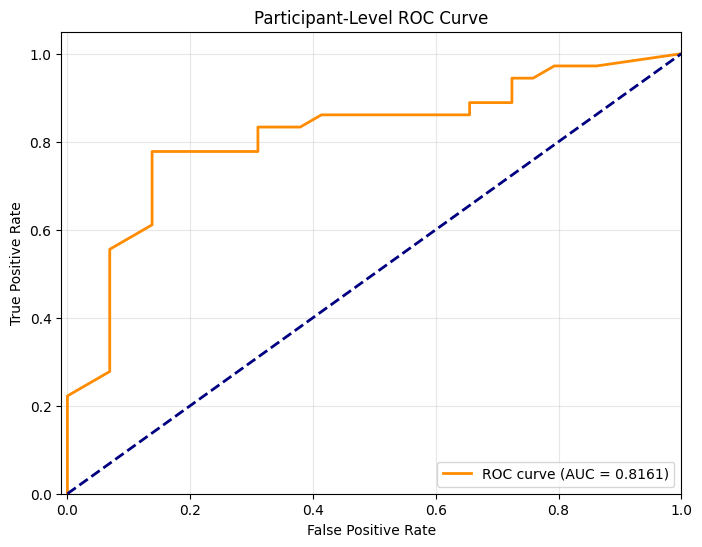

<Figure size 640x480 with 0 Axes>

In [24]:
# ------------------------------------------------------------------------------
# 8) Summarize results across participants
# ------------------------------------------------------------------------------
mean_accuracy = np.mean(all_acc)
mean_f1 = np.mean(all_f1)
total_conf_mat = np.sum(np.array(all_conf), axis=0)

print("\n================== Final Summary ==================")
print(f"Overall Participant-Level Accuracy: {mean_accuracy:.2f}%")
print(f"Overall Participant-Level F1 (Macro): {mean_f1:.4f}")
print("Participant-Level Confusion Matrix (summed):")
print(total_conf_mat)

# Show distribution of best thresholds across participants
print("\nBest thresholds chosen per participant:")
print(best_thresholds)

# If you want a single global threshold, you can do:
try:
    common_threshold = mode(best_thresholds)
except StatisticsError:
    # Fallback if no unique mode exists
    common_threshold = np.median(best_thresholds)
print(f"Common threshold across all participants: {common_threshold}")

# ------------------------------------------------------------------------------
# 9) Compute Participant-Level ROC AUC
# ------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score, roc_curve

participant_scores = np.array(participant_scores)           # shape: [num_participants]
participant_labels = np.array(participant_labels_list)     # shape: [num_participants]

# Check if there are both classes present
unique_participant_labels = np.unique(participant_labels)
if len(unique_participant_labels) == 2:
    participant_auc = roc_auc_score(participant_labels, participant_scores)
    print(f"\nParticipant-Level ROC AUC: {participant_auc:.4f}")

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(participant_labels, participant_scores)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {participant_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Participant-Level ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # Optionally, save the ROC curve plot
    plt.savefig('participant_level_roc_curve.png')
else:
    print("\nParticipant-Level ROC AUC not computed (only one class present).")


Confusion Matrix:
[[24  5]
 [ 8 28]]
Accuracy:  0.800
Precision: 0.848
Recall:    0.778
F1 score:  0.812
Specificity: 0.828
ROC AUC:   0.816
Avg Precision: 0.854

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        29
           1       0.85      0.78      0.81        36

    accuracy                           0.80        65
   macro avg       0.80      0.80      0.80        65
weighted avg       0.80      0.80      0.80        65

Confusion Matrix:
[[24  5]
 [ 8 28]]
Accuracy:    0.800
Precision:   0.848
Recall:      0.778
Specificity: 0.828
F1 Score:    0.812


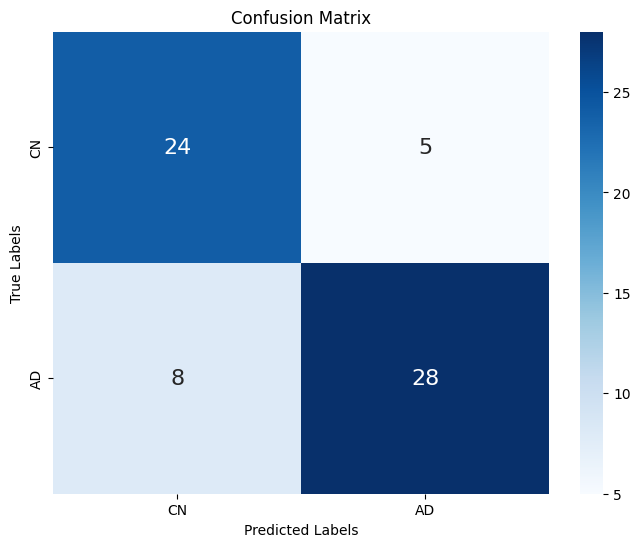

In [28]:
participant_predictions = []
for i in range(len(all_acc)):
    if participant_labels[i] == 1:  # Non-control
        predicted = 1 if all_acc[i] == 100.0 else 0
    else:                           # Control
        predicted = 0 if all_acc[i] == 100.0 else 1
    participant_predictions.append(predicted)


import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score)
from imblearn.metrics import specificity_score

# 1. If you want binary predictions, pick a threshold (commonly 0.5).
# threshold = 0.5
# participant_pred = (participant_scores >= threshold).astype(int)

participant_pred = participant_predictions
# 2. Confusion matrix (needs binary predictions)
cm = confusion_matrix(participant_labels, participant_pred)
print("Confusion Matrix:")
print(cm)

# 3. Accuracy, Precision, Recall, F1 (all use binary predictions)
acc = accuracy_score(participant_labels, participant_pred)
prec = precision_score(participant_labels, participant_pred)
rec = recall_score(participant_labels, participant_pred)
f1 = f1_score(participant_labels, participant_pred)
spec = specificity_score(participant_labels, participant_pred)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 score:  {f1:.3f}")
print(f"Specificity: {spec:.3f}")

# 4. ROC AUC (needs the raw probability or score, not just a hard prediction)
auc = roc_auc_score(participant_labels, participant_scores)
print(f"ROC AUC:   {auc:.3f}")

# 5. Average Precision (also uses the raw score)
avg_prec = average_precision_score(participant_labels, participant_scores)
print(f"Avg Precision: {avg_prec:.3f}")

# 6. Classification report (includes precision, recall, f1 for each class)
report = classification_report(participant_labels, participant_pred)
print("\nClassification Report:")
print(report)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrices (replace with your actual data)
# all_conf = [
#     [[22, 7],
#      [4, 32]],
#     # Add more confusion matrices if needed
# ]

# Sum the confusion matrices
cm = np.sum(np.array(all_conf), axis=0)

# Unpack the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = (tp + tn) / cm.sum()
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0        # a.k.a. Sensitivity
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"Recall:      {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score:    {f1:.3f}")

# Define class labels
labels = ['CN', "AD"]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 16}  # Increase annotation font size here
)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



In [ ]:
# class_weights = torch.tensor([1.0, 0.8], dtype=torch.float32, device=device)
# Confusion Matrix:
# [[25  4]
#  [ 7 29]]
# Accuracy:    0.831
# Precision:   0.879
# Recall:      0.806
# Specificity: 0.862
# F1 Score:    0.841
## class_weights = torch.tensor([1.0, 0.6], dtype=torch.float32, device=device)
# Confusion Matrix:
# [[26  3]
#  [ 7 29]]
# Accuracy:    0.846
# Precision:   0.906
# Recall:      0.806
# Specificity: 0.897
# F1 Score:    0.853

#ALZ

In [32]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
from statistics import mode, StatisticsError
import matplotlib.pyplot as plt

# Initialize accumulators for participant-level metrics
participant_scores = []       # Aggregated scores (e.g., alz_ratio) per participant
participant_labels_list = []  # Ground-truth labels per participant

seed = 42
set_seed(seed)  # Ensure reproducibility

# Define the model parameters
# Define the model parameters
input_dim_pte = 180   # Example: 11 * 5 * 6 * 6 = 180
hidden_dim_pte = 512
num_layers_pte = 2
num_heads_pte = 5     # Typically, num_heads should divide d_model
output_dim_pte = 128
dropout_pte = 0.4

input_dim_psd = 5
hidden_dim_psd = 512
num_layers_psd = 2
num_heads_psd = 5    # Typically, num_heads should divide d_model
output_dim_psd = 128
dropout_psd = 0.4

cross_d_model = 128
cross_num_heads = 8   # Number of heads in cross-attention

# Accumulators for overall metrics
all_acc = []
all_f1 = []
all_conf = []

# For global sample-level AUC
global_probs = []
global_labels = []

best_thresholds = []  # Store the chosen threshold for each participant

for participant in range(37, 89):
    print(f"\n===== Training for participant: {participant} =====")

    # --------------------------
    # 1) Initialize the model
    # --------------------------
    model = FinalModel(
        pte_input_dim=input_dim_pte, 
        pte_hidden_dim=hidden_dim_pte, 
        pte_num_layers=num_layers_pte, 
        pte_num_heads=num_heads_pte, 
        pte_output_dim=output_dim_pte, 
        pte_dropout=dropout_pte,
        psd_input_dim=input_dim_psd, 
        psd_hidden_dim=hidden_dim_psd, 
        psd_num_layers=num_layers_psd, 
        psd_num_heads=num_heads_psd, 
        psd_output_dim=output_dim_psd, 
        psd_dropout=dropout_psd,
        cross_d_model=cross_d_model, 
        cross_num_heads=cross_num_heads
    )

    # --------------------------
    # 2) Load data
    #    (Ensure your source_dataloader returns (pte, psd, labels, participant_id))
    # --------------------------
    source_dataloader, target_dataloader = load_combined_data(
        pte_directory="features",
        DE_directory="DE_features_single_window",
        target_participant=participant,
        batch_size=128,
        selected_classes=["ctrl", "ftd"],
        selected_channels=selected_channels,
        apply_smote=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Source data: {len(source_dataloader.dataset)} samples")
    print(f"Target data: {len(target_dataloader.dataset)} samples")

    # --------------------------
    # 3) Define Loss & Optimizer
    # --------------------------
    class_weights = torch.tensor([1.0, 0.8], dtype=torch.float32, device=device)
    criterion_label = nn.CrossEntropyLoss(weight=class_weights)
    criterion_domain = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-5) # 8e-5

    # --------------------------
    # 4) Train Model (DANN)
    # --------------------------
    num_epochs = 100
    lambda_grl = 0.0  # or use a schedule
    label_acc_history, domain_acc_history = train_model(
        model=model,
        source_dataloader=source_dataloader,
        target_dataloader=target_dataloader,
        criterion_label=criterion_label,
        criterion_domain=criterion_domain,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device    )
    print(f"Final Training Label Accuracy: {label_acc_history[-1]:.2f}%")

    # --------------------------
    # 5) Tune Threshold on Source
    # --------------------------
    # This step requires that your source_dataloader yield participant IDs
    thresholds_to_try = [0.2, 0.3, 0.4, 0.5]
    best_thr = tune_threshold_on_source(
        model=model,
        source_dataloader=source_dataloader,
        device=device,
        thresholds=thresholds_to_try,
        num_classes=2
    )
    best_thresholds.append(best_thr)

    # --------------------------
    # 6) Test on Target
    # --------------------------
    # We use the threshold we found above
    test_loss, test_acc, test_f1_score_part, participant_conf_mat, \
        participant_preds_softmax, participant_labels, alz_ratio, participant_true_label = test_model(
            model=model,
            test_dataloader=target_dataloader,
            criterion_label=criterion_label,
            device=device,
            num_classes=2,
            alz_threshold=best_thr,  # <--- using the best threshold
    )

    # --------------------------
    # 7) Store Participant-Level Metrics
    # --------------------------
    all_acc.append(test_acc)
    all_f1.append(test_f1_score_part)
    all_conf.append(participant_conf_mat)

    global_probs.append(participant_preds_softmax)
    global_labels.append(participant_labels)

    # Collect participant-level score and label for ROC AUC
    participant_scores.append(alz_ratio)               # Using alz_ratio as the score
    participant_labels_list.append(participant_true_label)  # Ground-truth label


Seed set to: 42

===== Training for participant: 37 =====

Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Final Training Label Accuracy: 63.75%
[Threshold 0.2] -> F1=0.7884 | Acc=0.7885
[Threshold 0.3] -> F1=0.7689 | Acc=0.7692
[Threshold 0.4] -> F1=0.7846 | Acc=0.7885
[Threshold 0.5] -> F1=0.7819 | Acc=0.7885

[Best Threshold] = 0.2 with F1=0.7884

Participant True Label: 0
 -> #Predicted ALZ samples: 3 / 12 = 0.25
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 38 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 62.66%
[Threshold 0.2] -> F1=0.6700 | Acc=0.6731
[Threshold 0.3] -> F1=0.7689 | Acc=0.7692
[Threshold 0.4] -> F1=0.8051 | Acc=0.8077
[Threshold 0.5] -> F1=0.7786 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.8051

Participant True Label: 0
 -> #Predicted ALZ samples: 7 / 14 = 0.50
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 39 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 61.41%
[Threshold 0.2] -> F1=0.8269 | Acc=0.8269
[Threshold 0.3] -> F1=0.8441 | Acc=0.8462
[Threshold 0.4] -> F1=0.8216 | Acc=0.8269
[Threshold 0.5] -> F1=0.8003 | Acc=0.8077

[Best Threshold] = 0.3 with F1=0.8441

Participant True Label: 0
 -> #Predicted ALZ samples: 8 / 14 = 0.57
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 40 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 108 synthetic samples.
Source data: 744 samples
Target data: 16 samples
Final Training Label Accuracy: 59.53%
[Threshold 0.2] -> F1=0.7492 | Acc=0.7500
[Threshold 0.3] -> F1=0.8216 | Acc=0.8269
[Threshold 0.4] -> F1=0.8402 | Acc=0.8462
[Threshold 0.5] -> F1=0.7744 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.8402

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 16 = 0.12
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 41 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 66.88%
[Threshold 0.2] -> F1=0.7106 | Acc=0.7115
[Threshold 0.3] -> F1=0.7865 | Acc=0.7885
[Threshold 0.4] -> F1=0.8612 | Acc=0.8654
[Threshold 0.5] -> F1=0.8402 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8612

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 14 = 0.00
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 42 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 108 synthetic samples.
Source data: 744 samples
Target data: 16 samples
Final Training Label Accuracy: 63.12%
[Threshold 0.2] -> F1=0.7689 | Acc=0.7692
[Threshold 0.3] -> F1=0.7846 | Acc=0.7885
[Threshold 0.4] -> F1=0.8402 | Acc=0.8462
[Threshold 0.5] -> F1=0.7969 | Acc=0.8077

[Best Threshold] = 0.4 with F1=0.8402

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 16 = 0.06
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 43 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 62.66%
[Threshold 0.2] -> F1=0.7292 | Acc=0.7308
[Threshold 0.3] -> F1=0.7604 | Acc=0.7692
[Threshold 0.4] -> F1=0.7562 | Acc=0.7692
[Threshold 0.5] -> F1=0.7512 | Acc=0.7692

[Best Threshold] = 0.3 with F1=0.7604

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 44 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 61.56%
[Threshold 0.2] -> F1=0.7492 | Acc=0.7500
[Threshold 0.3] -> F1=0.7661 | Acc=0.7692
[Threshold 0.4] -> F1=0.8030 | Acc=0.8077
[Threshold 0.5] -> F1=0.8188 | Acc=0.8269

[Best Threshold] = 0.5 with F1=0.8188

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 14 = 0.07
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 45 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 59.06%
[Threshold 0.2] -> F1=0.7499 | Acc=0.7500
[Threshold 0.3] -> F1=0.7661 | Acc=0.7692
[Threshold 0.4] -> F1=0.7383 | Acc=0.7500
[Threshold 0.5] -> F1=0.7451 | Acc=0.7692

[Best Threshold] = 0.3 with F1=0.7661

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 14 = 0.07
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 46 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples
Final Training Label Accuracy: 62.81%
[Threshold 0.2] -> F1=0.7477 | Acc=0.7500
[Threshold 0.3] -> F1=0.7604 | Acc=0.7692
[Threshold 0.4] -> F1=0.7969 | Acc=0.8077
[Threshold 0.5] -> F1=0.7512 | Acc=0.7692

[Best Threshold] = 0.4 with F1=0.7969

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 12 = 0.08
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 47 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 65.62%
[Threshold 0.2] -> F1=0.7878 | Acc=0.7885
[Threshold 0.3] -> F1=0.7661 | Acc=0.7692
[Threshold 0.4] -> F1=0.8030 | Acc=0.8077
[Threshold 0.5] -> F1=0.8188 | Acc=0.8269

[Best Threshold] = 0.5 with F1=0.8188

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 13 = 0.08
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 48 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 108 synthetic samples.
Source data: 744 samples
Target data: 16 samples
Final Training Label Accuracy: 61.41%
[Threshold 0.2] -> F1=0.7661 | Acc=0.7692
[Threshold 0.3] -> F1=0.7604 | Acc=0.7692
[Threshold 0.4] -> F1=0.7604 | Acc=0.7692
[Threshold 0.5] -> F1=0.7097 | Acc=0.7308

[Best Threshold] = 0.2 with F1=0.7661

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 16 = 0.38
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 49 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 63.59%
[Threshold 0.2] -> F1=0.8253 | Acc=0.8269
[Threshold 0.3] -> F1=0.8216 | Acc=0.8269
[Threshold 0.4] -> F1=0.8216 | Acc=0.8269
[Threshold 0.5] -> F1=0.7969 | Acc=0.8077

[Best Threshold] = 0.2 with F1=0.8253

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 13 = 0.31
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 50 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 65.78%
[Threshold 0.2] -> F1=0.7477 | Acc=0.7500
[Threshold 0.3] -> F1=0.8030 | Acc=0.8077
[Threshold 0.4] -> F1=0.8003 | Acc=0.8077
[Threshold 0.5] -> F1=0.7969 | Acc=0.8077

[Best Threshold] = 0.3 with F1=0.8030

Participant True Label: 0
 -> #Predicted ALZ samples: 9 / 13 = 0.69
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 51 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples
Final Training Label Accuracy: 62.34%
[Threshold 0.2] -> F1=0.7106 | Acc=0.7115
[Threshold 0.3] -> F1=0.7846 | Acc=0.7885
[Threshold 0.4] -> F1=0.7744 | Acc=0.7885
[Threshold 0.5] -> F1=0.7273 | Acc=0.7500

[Best Threshold] = 0.3 with F1=0.7846

Participant True Label: 0
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 52 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples
Final Training Label Accuracy: 66.88%
[Threshold 0.2] -> F1=0.7878 | Acc=0.7885
[Threshold 0.3] -> F1=0.8051 | Acc=0.8077
[Threshold 0.4] -> F1=0.7846 | Acc=0.7885
[Threshold 0.5] -> F1=0.7744 | Acc=0.7885

[Best Threshold] = 0.3 with F1=0.8051

Participant True Label: 0
 -> #Predicted ALZ samples: 6 / 12 = 0.50
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 53 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 59.22%
[Threshold 0.2] -> F1=0.7204 | Acc=0.7308
[Threshold 0.3] -> F1=0.7097 | Acc=0.7308
[Threshold 0.4] -> F1=0.6504 | Acc=0.6923
[Threshold 0.5] -> F1=0.6227 | Acc=0.6731

[Best Threshold] = 0.2 with F1=0.7204

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.2; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 54 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 60.31%
[Threshold 0.2] -> F1=0.8030 | Acc=0.8077
[Threshold 0.3] -> F1=0.7969 | Acc=0.8077
[Threshold 0.4] -> F1=0.7744 | Acc=0.7885
[Threshold 0.5] -> F1=0.7273 | Acc=0.7500

[Best Threshold] = 0.2 with F1=0.8030

Participant True Label: 0
 -> #Predicted ALZ samples: 1 / 13 = 0.08
 -> Threshold = 0.2; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 55 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 63.44%
[Threshold 0.2] -> F1=0.7292 | Acc=0.7308
[Threshold 0.3] -> F1=0.7292 | Acc=0.7308
[Threshold 0.4] -> F1=0.7423 | Acc=0.7500
[Threshold 0.5] -> F1=0.7786 | Acc=0.7885

[Best Threshold] = 0.5 with F1=0.7786

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 13 = 0.31
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 56 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 67.34%
[Threshold 0.2] -> F1=0.7689 | Acc=0.7692
[Threshold 0.3] -> F1=0.8237 | Acc=0.8269
[Threshold 0.4] -> F1=0.8375 | Acc=0.8462
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.8375

Participant True Label: 0
 -> #Predicted ALZ samples: 11 / 13 = 0.85
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 57 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 57.19%
[Threshold 0.2] -> F1=0.7846 | Acc=0.7885
[Threshold 0.3] -> F1=0.8003 | Acc=0.8077
[Threshold 0.4] -> F1=0.8188 | Acc=0.8269
[Threshold 0.5] -> F1=0.7927 | Acc=0.8077

[Best Threshold] = 0.4 with F1=0.8188

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 58 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples
Final Training Label Accuracy: 64.38%
[Threshold 0.2] -> F1=0.7865 | Acc=0.7885
[Threshold 0.3] -> F1=0.7636 | Acc=0.7692
[Threshold 0.4] -> F1=0.7786 | Acc=0.7885
[Threshold 0.5] -> F1=0.6854 | Acc=0.7115

[Best Threshold] = 0.2 with F1=0.7865

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 12 = 0.17
 -> Threshold = 0.2; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 59 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 65.00%
[Threshold 0.2] -> F1=0.8065 | Acc=0.8077
[Threshold 0.3] -> F1=0.8051 | Acc=0.8077
[Threshold 0.4] -> F1=0.7562 | Acc=0.7692
[Threshold 0.5] -> F1=0.7744 | Acc=0.7885

[Best Threshold] = 0.2 with F1=0.8065

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 13 = 0.15
 -> Threshold = 0.2; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 60 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 112 synthetic samples.
Source data: 752 samples
Target data: 12 samples
Final Training Label Accuracy: 62.50%
[Threshold 0.2] -> F1=0.7661 | Acc=0.7692
[Threshold 0.3] -> F1=0.8003 | Acc=0.8077
[Threshold 0.4] -> F1=0.7562 | Acc=0.7692
[Threshold 0.5] -> F1=0.7097 | Acc=0.7308

[Best Threshold] = 0.3 with F1=0.8003

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 12 = 0.00
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 61 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 61.25%
[Threshold 0.2] -> F1=0.7865 | Acc=0.7885
[Threshold 0.3] -> F1=0.7846 | Acc=0.7885
[Threshold 0.4] -> F1=0.8030 | Acc=0.8077
[Threshold 0.5] -> F1=0.7786 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.8030

Participant True Label: 0
 -> #Predicted ALZ samples: 5 / 13 = 0.38
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 62 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 62.19%
[Threshold 0.2] -> F1=0.7114 | Acc=0.7115
[Threshold 0.3] -> F1=0.7477 | Acc=0.7500
[Threshold 0.4] -> F1=0.7636 | Acc=0.7692
[Threshold 0.5] -> F1=0.8003 | Acc=0.8077

[Best Threshold] = 0.5 with F1=0.8003

Participant True Label: 0
 -> #Predicted ALZ samples: 2 / 14 = 0.14
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 63 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 111 synthetic samples.
Source data: 750 samples
Target data: 13 samples
Final Training Label Accuracy: 59.06%
[Threshold 0.2] -> F1=0.6518 | Acc=0.6538
[Threshold 0.3] -> F1=0.7114 | Acc=0.7115
[Threshold 0.4] -> F1=0.7865 | Acc=0.7885
[Threshold 0.5] -> F1=0.8188 | Acc=0.8269

[Best Threshold] = 0.5 with F1=0.8188

Participant True Label: 0
 -> #Predicted ALZ samples: 4 / 13 = 0.31
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 64 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 60.16%
[Threshold 0.2] -> F1=0.7846 | Acc=0.7885
[Threshold 0.3] -> F1=0.8188 | Acc=0.8269
[Threshold 0.4] -> F1=0.7969 | Acc=0.8077
[Threshold 0.5] -> F1=0.6770 | Acc=0.7115

[Best Threshold] = 0.3 with F1=0.8188

Participant True Label: 0
 -> #Predicted ALZ samples: 0 / 14 = 0.00
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 65 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 110 synthetic samples.
Source data: 748 samples
Target data: 14 samples
Final Training Label Accuracy: 63.12%
[Threshold 0.2] -> F1=0.8074 | Acc=0.8077
[Threshold 0.3] -> F1=0.8051 | Acc=0.8077
[Threshold 0.4] -> F1=0.7819 | Acc=0.7885
[Threshold 0.5] -> F1=0.7969 | Acc=0.8077

[Best Threshold] = 0.2 with F1=0.8074

Participant True Label: 0
 -> #Predicted ALZ samples: 5 / 14 = 0.36
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 66 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 133 synthetic samples.
Source data: 776 samples
Target data: 9 samples
Final Training Label Accuracy: 62.89%
[Threshold 0.2] -> F1=0.8216 | Acc=0.8269
[Threshold 0.3] -> F1=0.7969 | Acc=0.8077
[Threshold 0.4] -> F1=0.8154 | Acc=0.8269
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.2 with F1=0.8216

Participant True Label: 1
 -> #Predicted ALZ samples: 8 / 9 = 0.89
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 67 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 66.28%
[Threshold 0.2] -> F1=0.7865 | Acc=0.7885
[Threshold 0.3] -> F1=0.8188 | Acc=0.8269
[Threshold 0.4] -> F1=0.7927 | Acc=0.8077
[Threshold 0.5] -> F1=0.7927 | Acc=0.8077

[Best Threshold] = 0.3 with F1=0.8188

Participant True Label: 1
 -> #Predicted ALZ samples: 5 / 10 = 0.50
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 68 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 133 synthetic samples.
Source data: 776 samples
Target data: 9 samples
Final Training Label Accuracy: 64.71%
[Threshold 0.2] -> F1=0.7106 | Acc=0.7115
[Threshold 0.3] -> F1=0.7454 | Acc=0.7500
[Threshold 0.4] -> F1=0.8375 | Acc=0.8462
[Threshold 0.5] -> F1=0.8154 | Acc=0.8269

[Best Threshold] = 0.4 with F1=0.8375

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 9 = 0.22
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 69 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 59.11%
[Threshold 0.2] -> F1=0.7512 | Acc=0.7692
[Threshold 0.3] -> F1=0.6770 | Acc=0.7115
[Threshold 0.4] -> F1=0.5457 | Acc=0.6346
[Threshold 0.5] -> F1=0.5248 | Acc=0.6346

[Best Threshold] = 0.2 with F1=0.7512

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 10 = 0.70
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 70 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 131 synthetic samples.
Source data: 776 samples
Target data: 7 samples
Final Training Label Accuracy: 65.62%
[Threshold 0.2] -> F1=0.7308 | Acc=0.7308
[Threshold 0.3] -> F1=0.7271 | Acc=0.7308
[Threshold 0.4] -> F1=0.8188 | Acc=0.8269
[Threshold 0.5] -> F1=0.8375 | Acc=0.8462

[Best Threshold] = 0.5 with F1=0.8375

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 7 = 0.29
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 71 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 64.19%
[Threshold 0.2] -> F1=0.7454 | Acc=0.7500
[Threshold 0.3] -> F1=0.7819 | Acc=0.7885
[Threshold 0.4] -> F1=0.7969 | Acc=0.8077
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.7969

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 10 = 0.70
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 72 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 63.93%
[Threshold 0.2] -> F1=0.7114 | Acc=0.7115
[Threshold 0.3] -> F1=0.7661 | Acc=0.7692
[Threshold 0.4] -> F1=0.7604 | Acc=0.7692
[Threshold 0.5] -> F1=0.7512 | Acc=0.7692

[Best Threshold] = 0.3 with F1=0.7661

Participant True Label: 1
 -> #Predicted ALZ samples: 9 / 10 = 0.90
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 73 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 138 synthetic samples.
Source data: 776 samples
Target data: 14 samples
Final Training Label Accuracy: 64.19%
[Threshold 0.2] -> F1=0.7492 | Acc=0.7500
[Threshold 0.3] -> F1=0.7661 | Acc=0.7692
[Threshold 0.4] -> F1=0.8188 | Acc=0.8269
[Threshold 0.5] -> F1=0.7927 | Acc=0.8077

[Best Threshold] = 0.4 with F1=0.8188

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 14 = 0.50
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 74 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 140 synthetic samples.
Source data: 776 samples
Target data: 16 samples
Final Training Label Accuracy: 62.50%
[Threshold 0.2] -> F1=0.7878 | Acc=0.7885
[Threshold 0.3] -> F1=0.7819 | Acc=0.7885
[Threshold 0.4] -> F1=0.7744 | Acc=0.7885
[Threshold 0.5] -> F1=0.7876 | Acc=0.8077

[Best Threshold] = 0.2 with F1=0.7878

Participant True Label: 1
 -> #Predicted ALZ samples: 9 / 16 = 0.56
 -> Threshold = 0.2; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 75 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 136 synthetic samples.
Source data: 776 samples
Target data: 12 samples
Final Training Label Accuracy: 65.76%
[Threshold 0.2] -> F1=0.7292 | Acc=0.7308
[Threshold 0.3] -> F1=0.7846 | Acc=0.7885
[Threshold 0.4] -> F1=0.8154 | Acc=0.8269
[Threshold 0.5] -> F1=0.7927 | Acc=0.8077

[Best Threshold] = 0.4 with F1=0.8154

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 12 = 0.58
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 76 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 137 synthetic samples.
Source data: 776 samples
Target data: 13 samples
Final Training Label Accuracy: 63.41%
[Threshold 0.2] -> F1=0.7499 | Acc=0.7500
[Threshold 0.3] -> F1=0.7679 | Acc=0.7692
[Threshold 0.4] -> F1=0.8402 | Acc=0.8462
[Threshold 0.5] -> F1=0.7876 | Acc=0.8077

[Best Threshold] = 0.4 with F1=0.8402

Participant True Label: 1
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 77 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 135 synthetic samples.
Source data: 776 samples
Target data: 11 samples
Final Training Label Accuracy: 62.37%
[Threshold 0.2] -> F1=0.7661 | Acc=0.7692
[Threshold 0.3] -> F1=0.8003 | Acc=0.8077
[Threshold 0.4] -> F1=0.7969 | Acc=0.8077
[Threshold 0.5] -> F1=0.6671 | Acc=0.7115

[Best Threshold] = 0.3 with F1=0.8003

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 11 = 0.18
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 78 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 138 synthetic samples.
Source data: 776 samples
Target data: 14 samples
Final Training Label Accuracy: 63.54%
[Threshold 0.2] -> F1=0.6882 | Acc=0.6923
[Threshold 0.3] -> F1=0.7106 | Acc=0.7115
[Threshold 0.4] -> F1=0.7304 | Acc=0.7308
[Threshold 0.5] -> F1=0.7271 | Acc=0.7308

[Best Threshold] = 0.4 with F1=0.7304

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 14 = 0.14
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 79 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 137 synthetic samples.
Source data: 776 samples
Target data: 13 samples
Final Training Label Accuracy: 65.10%
[Threshold 0.2] -> F1=0.7661 | Acc=0.7692
[Threshold 0.3] -> F1=0.7819 | Acc=0.7885
[Threshold 0.4] -> F1=0.8003 | Acc=0.8077
[Threshold 0.5] -> F1=0.7562 | Acc=0.7692

[Best Threshold] = 0.4 with F1=0.8003

Participant True Label: 1
 -> #Predicted ALZ samples: 0 / 13 = 0.00
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 80 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 139 synthetic samples.
Source data: 776 samples
Target data: 15 samples
Final Training Label Accuracy: 66.80%
[Threshold 0.2] -> F1=0.8269 | Acc=0.8269
[Threshold 0.3] -> F1=0.9021 | Acc=0.9038
[Threshold 0.4] -> F1=0.8375 | Acc=0.8462
[Threshold 0.5] -> F1=0.8154 | Acc=0.8269

[Best Threshold] = 0.3 with F1=0.9021

Participant True Label: 1
 -> #Predicted ALZ samples: 1 / 15 = 0.07
 -> Threshold = 0.3; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 81 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 137 synthetic samples.
Source data: 776 samples
Target data: 13 samples
Final Training Label Accuracy: 65.10%
[Threshold 0.2] -> F1=0.7292 | Acc=0.7308
[Threshold 0.3] -> F1=0.7786 | Acc=0.7885
[Threshold 0.4] -> F1=0.7927 | Acc=0.8077
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.7927

Participant True Label: 1
 -> #Predicted ALZ samples: 13 / 13 = 1.00
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 82 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 136 synthetic samples.
Source data: 776 samples
Target data: 12 samples
Final Training Label Accuracy: 67.45%
[Threshold 0.2] -> F1=0.8077 | Acc=0.8077
[Threshold 0.3] -> F1=0.8253 | Acc=0.8269
[Threshold 0.4] -> F1=0.8375 | Acc=0.8462
[Threshold 0.5] -> F1=0.8375 | Acc=0.8462

[Best Threshold] = 0.4 with F1=0.8375

Participant True Label: 1
 -> #Predicted ALZ samples: 1 / 12 = 0.08
 -> Threshold = 0.4; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 83 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 139 synthetic samples.
Source data: 776 samples
Target data: 15 samples
Final Training Label Accuracy: 61.72%
[Threshold 0.2] -> F1=0.6670 | Acc=0.6731
[Threshold 0.3] -> F1=0.7114 | Acc=0.7115
[Threshold 0.4] -> F1=0.7204 | Acc=0.7308
[Threshold 0.5] -> F1=0.7333 | Acc=0.7500

[Best Threshold] = 0.5 with F1=0.7333

Participant True Label: 1
 -> #Predicted ALZ samples: 2 / 15 = 0.13
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000

===== Training for participant: 84 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 64.71%
[Threshold 0.2] -> F1=0.7114 | Acc=0.7115
[Threshold 0.3] -> F1=0.7477 | Acc=0.7500
[Threshold 0.4] -> F1=0.8154 | Acc=0.8269
[Threshold 0.5] -> F1=0.8154 | Acc=0.8269

[Best Threshold] = 0.4 with F1=0.8154

Participant True Label: 1
 -> #Predicted ALZ samples: 6 / 10 = 0.60
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 85 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 133 synthetic samples.
Source data: 776 samples
Target data: 9 samples
Final Training Label Accuracy: 67.06%
[Threshold 0.2] -> F1=0.7454 | Acc=0.7500
[Threshold 0.3] -> F1=0.8003 | Acc=0.8077
[Threshold 0.4] -> F1=0.8154 | Acc=0.8269
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.4 with F1=0.8154

Participant True Label: 1
 -> #Predicted ALZ samples: 4 / 9 = 0.44
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 86 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 133 synthetic samples.
Source data: 776 samples
Target data: 9 samples
Final Training Label Accuracy: 63.28%
[Threshold 0.2] -> F1=0.7661 | Acc=0.7692
[Threshold 0.3] -> F1=0.7786 | Acc=0.7885
[Threshold 0.4] -> F1=0.7744 | Acc=0.7885
[Threshold 0.5] -> F1=0.7693 | Acc=0.7885

[Best Threshold] = 0.3 with F1=0.7786

Participant True Label: 1
 -> #Predicted ALZ samples: 7 / 9 = 0.78
 -> Threshold = 0.3; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 87 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 134 synthetic samples.
Source data: 776 samples
Target data: 10 samples
Final Training Label Accuracy: 63.28%
[Threshold 0.2] -> F1=0.7819 | Acc=0.7885
[Threshold 0.3] -> F1=0.7562 | Acc=0.7692
[Threshold 0.4] -> F1=0.7927 | Acc=0.8077
[Threshold 0.5] -> F1=0.7201 | Acc=0.7500

[Best Threshold] = 0.4 with F1=0.7927

Participant True Label: 1
 -> #Predicted ALZ samples: 9 / 10 = 0.90
 -> Threshold = 0.4; Final Participant Prediction: 1
 -> Participant Accuracy: 100.00%
 -> Participant F1 (Macro): 1.0000

===== Training for participant: 88 =====


/home/s.dharia-ra/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



Applying SMOTE to the source data...
SMOTE created 137 synthetic samples.
Source data: 776 samples
Target data: 13 samples
Final Training Label Accuracy: 64.19%
[Threshold 0.2] -> F1=0.7692 | Acc=0.7692
[Threshold 0.3] -> F1=0.7878 | Acc=0.7885
[Threshold 0.4] -> F1=0.8003 | Acc=0.8077
[Threshold 0.5] -> F1=0.8154 | Acc=0.8269

[Best Threshold] = 0.5 with F1=0.8154

Participant True Label: 1
 -> #Predicted ALZ samples: 4 / 13 = 0.31
 -> Threshold = 0.5; Final Participant Prediction: 0
 -> Participant Accuracy: 0.00%
 -> Participant F1 (Macro): 0.0000



================== Final Summary ==================
Overall Participant-Level Accuracy: 61.54%
Overall Participant-Level F1 (Macro): 0.6154
Participant-Level Confusion Matrix (summed):
[[19 10]
 [10 13]]

Best thresholds chosen per participant:
[0.2, 0.4, 0.3, 0.4, 0.4, 0.4, 0.3, 0.5, 0.3, 0.4, 0.5, 0.2, 0.2, 0.3, 0.3, 0.3, 0.2, 0.2, 0.5, 0.4, 0.4, 0.2, 0.2, 0.3, 0.4, 0.5, 0.5, 0.3, 0.2, 0.2, 0.3, 0.4, 0.2, 0.5, 0.4, 0.3, 0.4, 0.2, 0.4, 0.4, 0.3, 0.4, 0.4, 0.3, 0.4, 0.4, 0.5, 0.4, 0.4, 0.3, 0.4, 0.5]
Common threshold across all participants: 0.4

Participant-Level ROC AUC: 0.7016


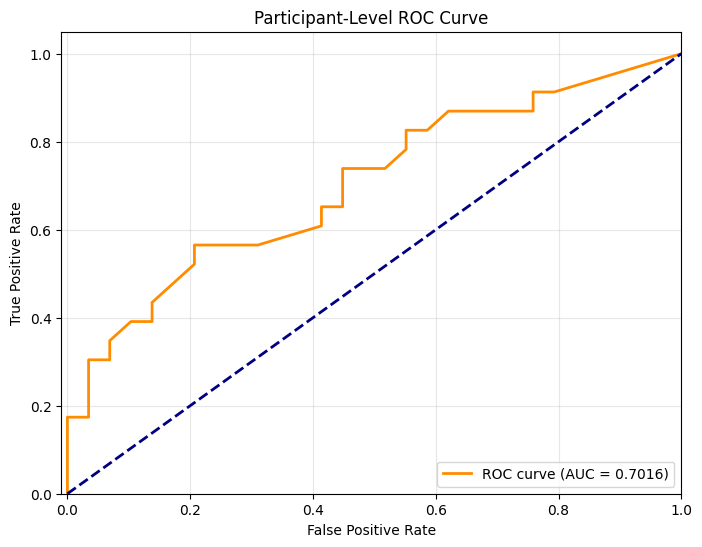

<Figure size 640x480 with 0 Axes>

In [33]:
# ------------------------------------------------------------------------------
# 8) Summarize results across participants
# ------------------------------------------------------------------------------
mean_accuracy = np.mean(all_acc)
mean_f1 = np.mean(all_f1)
total_conf_mat = np.sum(np.array(all_conf), axis=0)

print("\n================== Final Summary ==================")
print(f"Overall Participant-Level Accuracy: {mean_accuracy:.2f}%")
print(f"Overall Participant-Level F1 (Macro): {mean_f1:.4f}")
print("Participant-Level Confusion Matrix (summed):")
print(total_conf_mat)

# Show distribution of best thresholds across participants
print("\nBest thresholds chosen per participant:")
print(best_thresholds)

# If you want a single global threshold, you can do:
try:
    common_threshold = mode(best_thresholds)
except StatisticsError:
    # Fallback if no unique mode exists
    common_threshold = np.median(best_thresholds)
print(f"Common threshold across all participants: {common_threshold}")

# ------------------------------------------------------------------------------
# 9) Compute Participant-Level ROC AUC
# ------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score, roc_curve

participant_scores = np.array(participant_scores)           # shape: [num_participants]
participant_labels = np.array(participant_labels_list)     # shape: [num_participants]

# Check if there are both classes present
unique_participant_labels = np.unique(participant_labels)
if len(unique_participant_labels) == 2:
    participant_auc = roc_auc_score(participant_labels, participant_scores)
    print(f"\nParticipant-Level ROC AUC: {participant_auc:.4f}")

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(participant_labels, participant_scores)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {participant_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Participant-Level ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # Optionally, save the ROC curve plot
    plt.savefig('participant_level_roc_curve.png')
else:
    print("\nParticipant-Level ROC AUC not computed (only one class present).")


Confusion Matrix:
[[19 10]
 [10 13]]
Accuracy:  0.615
Precision: 0.565
Recall:    0.565
F1 score:  0.565
Specificity: 0.655
ROC AUC:   0.702
Avg Precision: 0.698

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        29
           1       0.57      0.57      0.57        23

    accuracy                           0.62        52
   macro avg       0.61      0.61      0.61        52
weighted avg       0.62      0.62      0.62        52

Confusion Matrix:
[[19 10]
 [10 13]]
Accuracy:    0.615
Precision:   0.565
Recall:      0.565
Specificity: 0.655
F1 Score:    0.565


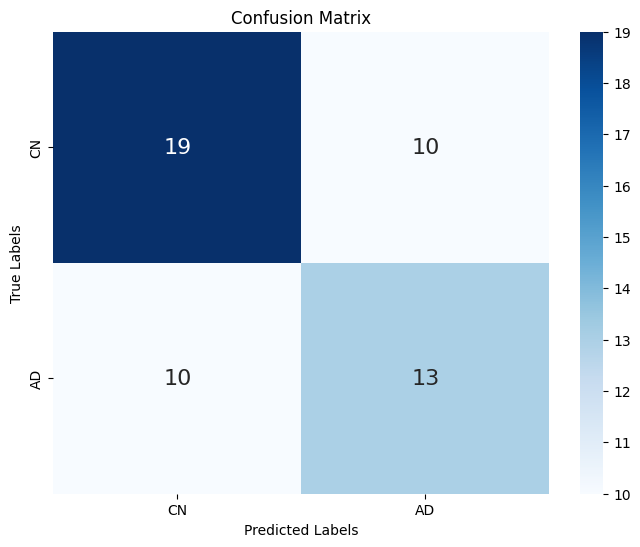

In [34]:
participant_predictions = []
for i in range(len(all_acc)):
    if participant_labels[i] == 1:  # Non-control
        predicted = 1 if all_acc[i] == 100.0 else 0
    else:                           # Control
        predicted = 0 if all_acc[i] == 100.0 else 1
    participant_predictions.append(predicted)


import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score)
from imblearn.metrics import specificity_score

# 1. If you want binary predictions, pick a threshold (commonly 0.5).
# threshold = 0.5
# participant_pred = (participant_scores >= threshold).astype(int)

participant_pred = participant_predictions
# 2. Confusion matrix (needs binary predictions)
cm = confusion_matrix(participant_labels, participant_pred)
print("Confusion Matrix:")
print(cm)

# 3. Accuracy, Precision, Recall, F1 (all use binary predictions)
acc = accuracy_score(participant_labels, participant_pred)
prec = precision_score(participant_labels, participant_pred)
rec = recall_score(participant_labels, participant_pred)
f1 = f1_score(participant_labels, participant_pred)
spec = specificity_score(participant_labels, participant_pred)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 score:  {f1:.3f}")
print(f"Specificity: {spec:.3f}")

# 4. ROC AUC (needs the raw probability or score, not just a hard prediction)
auc = roc_auc_score(participant_labels, participant_scores)
print(f"ROC AUC:   {auc:.3f}")

# 5. Average Precision (also uses the raw score)
avg_prec = average_precision_score(participant_labels, participant_scores)
print(f"Avg Precision: {avg_prec:.3f}")

# 6. Classification report (includes precision, recall, f1 for each class)
report = classification_report(participant_labels, participant_pred)
print("\nClassification Report:")
print(report)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrices (replace with your actual data)
# all_conf = [
#     [[22, 7],
#      [4, 32]],
#     # Add more confusion matrices if needed
# ]

# Sum the confusion matrices
cm = np.sum(np.array(all_conf), axis=0)

# Unpack the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = (tp + tn) / cm.sum()
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0        # a.k.a. Sensitivity
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"Recall:      {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score:    {f1:.3f}")

# Define class labels
labels = ['CN', "AD"]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 16}  # Increase annotation font size here
)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

